# Product Segmentation and Customer Classification in an Online Retail Company

In this project we'll do RFM analysis from a 2-years-worth of data in online retail. We're taking a dataset from [Online Retail II UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/502/online+retail+ii), containing all the transactions occuring for a UK-based and registered, non-store online retail between 01/12/2009 to 09/12/2011. Many customers of the company are wholesalers.

This data consists of eight columns:

* `InvoiceNo` : Invoice Number; Code starting with 'C' indicates a cancellation,
* `StockCode` : Product (item) code; 5-digit integral number assigned to each distinct product,
* `Description` : Product (item) name,
* `Quantity` : The number of product (item) bought per transaction,
* `InvoiceDate` : Invoice date and time,
* `UnitPrice` : Product price per unit (in poundsterling),
* `Customer ID` : Customer number as identifier, and
* `Country` : Name of country where the customer resides.

And the project will consists of three parts, all in this notebook:
* Part 1: **EDA and Data Cleaning**
* Part 2: **Product Segmentation**
* Part 3: **Customer Classification**

References: [Fabien Daniel, Customer Segmentation](https://www.kaggle.com/code/fabiendaniel/customer-segmentation)

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Visualizations across sections
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

# Ignoring warning to free up spaces
import warnings
warnings.filterwarnings('ignore')

import nltk # Tokenizing words
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS # Making wordclouds

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

# Classification
import itertools
from sklearn.model_selection import (
    train_test_split, GridSearchCV, learning_curve)
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split, GridSearchCV, learning_curve)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, 
    GradientBoostingClassifier, VotingClassifier)

In [2]:
# import pandas as pd
# Uncomment this if you only have .xlsx file in hand

# ## (Option 1) Separating the file into csv per sheets
# # for sheet_name, df in pd.read_excel(
# #     'online_retail_II.xlsx', index_col=0, sheet_name=None).items():
# #     df.to_csv(f'online_retail_II_{sheet_name}.csv', index=False, encoding='utf-8')

# # (Option 2) Combining the sheets into a single csv
# combined_dfs = []

# for sheet_name, df in pd.read_excel(
#     'online_retail_II.xlsx',sheet_name=None).items():
    
#     # Version 1: Original append
#     combined_dfs.append(df)

# combined_dfs = pd.concat(combined_dfs)
# combined_dfs.to_csv('online_retail_II.csv', index=False)

In [3]:
combined_dfs = pd.read_csv('online_retail_II.csv')

In [4]:
combined_dfs.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Part 1: EDA and Data Cleaning

We're making a new column of `revenue: Quantity * Price` for data cleaning up to prediction.

In [5]:
combined_dfs['InvoiceDate'] = pd.to_datetime(combined_dfs['InvoiceDate'])
combined_dfs['revenue'] = combined_dfs['Price'] * combined_dfs['Quantity']

In [6]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [7]:
combined_dfs.shape

(1067371, 9)

In [8]:
combined_dfs.describe()

,Quantity,InvoiceDate,Price,Customer ID,revenue
count,1.067371e+06,1067371,1.067371e+06,824364.000000,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504,1.806987e+01
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,-1.684696e+05
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000,3.750000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,9.900000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,1.684696e+05
std,1.727058e+02,NaN,1.235531e+02,1697.464450,2.924202e+02


### Missing Values

To make sure we run the machine learning model into our data smoothly, we need to make sure there's no missing values.

In [9]:
combined_dfs.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
revenue             0
dtype: int64

In [10]:
combined_dfs.loc[combined_dfs['Customer ID'].isna()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom,-0.00
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom,-0.00
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,0.55


In [11]:
combined_dfs.loc[combined_dfs['Description'].isna()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom,-0.0
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom,-0.0
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom,0.0
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom,0.0
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom,-0.0


In [12]:
combined_dfs.loc[combined_dfs['Customer ID'].isna(), 'Price'].value_counts()

Price
2.46       16081
2.51       14861
4.13       14804
1.66       12704
1.63       12027
           ...  
0.60           1
124.46         1
163.15         1
107.85         1
1714.17        1
Name: count, Length: 2155, dtype: int64

In [13]:
combined_dfs.loc[combined_dfs['Description'].isna(), 'Price'].value_counts()

Price
0.0    4382
Name: count, dtype: int64

We won't know one's customer behavior through RFM without knowing its `Customer ID` as an identifier and `Price` fort the monetary value (in the missing values of `Description`, all values have a price of `0.0`), so in this case we'll just drop them out.

In [14]:
combined_dfs = combined_dfs.dropna(subset=['Customer ID', 'Description'])
combined_dfs = combined_dfs.drop_duplicates(
    subset=['Customer ID', 'StockCode', 'InvoiceDate'])

In [15]:
combined_dfs.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
revenue        0
dtype: int64

### Checking Columns:

### `Invoice` -- Checking Returns and Invalid Invoices 

In [16]:
combined_dfs.sort_values(['Invoice']).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [17]:
combined_dfs.sort_values(['Invoice']).tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
1067178,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-6.25
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


In [18]:
combined_dfs.sort_values('Price')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
655649,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.00,13239.0,United Kingdom,0.00
804784,561284,22167,OVAL WALL MIRROR DIAMANTE,1,2011-07-26 12:24:00,0.00,16818.0,United Kingdom,0.00
972254,574920,22899,CHILDREN'S APRON DOLLY GIRL,1,2011-11-07 16:34:00,0.00,13985.0,United Kingdom,0.00
823515,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.00,14911.0,EIRE,0.00
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.0,United Kingdom,0.00
...,...,...,...,...,...,...,...,...,...
135012,C502262,M,Manual,-1,2010-03-23 15:20:00,10953.50,12918.0,United Kingdom,-10953.50
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom,10953.50
135014,C502264,M,Manual,-1,2010-03-23 15:24:00,10953.50,12918.0,United Kingdom,-10953.50
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom,-25111.09


In [19]:
combined_dfs.loc[combined_dfs['Invoice'].str.startswith('C', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.9
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.0
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.6
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4


In [20]:
combined_dfs.loc[combined_dfs['Invoice'].str.startswith('C', na=False)].sort_values('Price', ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.00
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom,-25111.09
135012,C502262,M,Manual,-1,2010-03-23 15:20:00,10953.50,12918.0,United Kingdom,-10953.50
135014,C502264,M,Manual,-1,2010-03-23 15:24:00,10953.50,12918.0,United Kingdom,-10953.50
372833,C525398,M,Manual,-1,2010-10-05 11:47:00,10468.80,14063.0,United Kingdom,-10468.80


In [21]:
combined_dfs.loc[combined_dfs['StockCode'] == 'M'].describe()

,Quantity,InvoiceDate,Price,Customer ID,revenue
count,982.000000,982,982.000000,982.000000,982.000000
mean,3.973523,2010-11-21 19:25:20.835030272,466.614460,15280.122200,-186.945957
min,-1350.000000,2009-12-01 16:48:00,0.000000,12346.000000,-38970.000000
25%,-1.000000,2010-05-06 11:43:30,1.000000,13767.000000,-33.142500
50%,1.000000,2010-10-15 14:58:30,5.100000,15202.000000,1.615000
75%,2.000000,2011-05-24 10:57:00,224.662500,16883.500000,10.060000
max,1600.000000,2011-12-09 10:28:00,38970.000000,18283.000000,10953.500000
std,93.303913,NaN,1927.705019,1757.287278,1988.555113


Some invoices have an item returned for a whopping thousands of dollars, way off than the rest of the data. These data also belong to a  `StockCode` of `M`, and `Description` of  `Manual`.

These data seems to not portray one's customer behavior. Even if we'll put it into account, it'll become outliers compared to other transactions, seeing that each product costs in range of 0-10 pounds. We'll clean it in the next section.

There's also another types of `StockCode` that may give us invalid data; take `D` and `POST`, for instance--they have one same `StockCode` as product identifier, yet the prices differ. 

The dataset tells us that `StockCode` returns a product identifier which contains at least 5 numbers. We need to check them further first in the column `Description`.

### `StockCode` and `Description`: Types of Transaction

In this column, we'll check what kind of transactions there are in the dataset.

In [22]:
## Searching for Stock Codes besides the format:
### 5 digits, optionally followed by an uppercase. e.g. 79323P
non_digit_stock_code = combined_dfs.loc[~(combined_dfs['StockCode']
                           .str.contains(r'^\d{5}(?:[A-Z])?$')), :]

non_digit_stock_code.value_counts(['StockCode'])

StockCode   
POST            1978
M                982
15056BL          800
C2               254
79323LP          218
D                148
79323GR          113
ADJUST            61
BANK CHARGES      36
PADS              19
CRUK              16
DOT               16
TEST001           15
ADJUST2            3
SP1002             2
TEST002            1
Name: count, dtype: int64

In [23]:
non_digit_stock_code.value_counts(['StockCode', 'Description'])

StockCode     Description                        
POST          POSTAGE                                1978
M             Manual                                  982
15056BL       EDWARDIAN PARASOL BLACK                 800
C2            CARRIAGE                                254
79323LP       LIGHT PINK CHERRY LIGHTS                218
D             Discount                                148
79323GR       GREEN CHERRY LIGHTS                     113
ADJUST        Adjustment by john on 26/01/2010 16      36
BANK CHARGES  Bank Charges                             33
ADJUST        Adjustment by john on 26/01/2010 17      22
PADS          PADS TO MATCH ALL CUSHIONS               19
CRUK          CRUK Commission                          16
DOT           DOTCOM POSTAGE                           16
TEST001       This is a test product.                  15
ADJUST2       Adjustment by Peter on Jun 25 2010        3
BANK CHARGES   Bank Charges                             3
ADJUST        Adjustme

After filtering, we have 5 products, `D` for discount, and the rest includes  other transactions:

* `M` as in `Manual` for manual input, 
* test products as in `TEST001` and `TEST002`, 
* payments like `BANK CHARGES` and `CRUK` for `CRUK Commission`, 
* up to delivery fee, as shown in both `POSTAGE` and also `CARRIAGE`. 

These are not relevant to the product transactions and some of them differs in extreme range. So in this case, we'll clean them all.

In [24]:
stock_codes_to_clean = ['M', 'POST', 'C2', 'CRUK', 'DOT', 'BANK CHARGES', 
                        'ADJUST', 'TEST001', 'ADJUST2', 'SP1002']

combined_dfs = combined_dfs.loc[~combined_dfs['StockCode'].isin(stock_codes_to_clean)]

### `Price`: Price Check

In [25]:
combined_dfs.sort_values('Price', ascending=False)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
676052,C549452,D,Discount,-1,2011-04-08 14:17:00,1867.86,17940.0,United Kingdom,-1867.86
450818,C532255,D,Discount,-1,2010-11-11 12:50:00,1269.51,14088.0,United Kingdom,-1269.51
95554,C498420,D,Discount,-1,2010-02-18 16:25:00,947.08,14646.0,Netherlands,-947.08
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
748143,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom,649.50
...,...,...,...,...,...,...,...,...,...
149202,503585,22458,CAST IRON HOOK GARDEN FORK,8,2010-04-01 17:13:00,0.00,13047.0,United Kingdom,0.00
512240,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.00,12647.0,Germany,0.00
884131,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.00,16133.0,United Kingdom,0.00
840209,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.00,14646.0,Netherlands,0.00


In [26]:
combined_dfs[combined_dfs['Price'] == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom,0.0
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom,0.0
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0.0
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0.0
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258.0,United Kingdom,0.0
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.0,12417.0,Belgium,0.0
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858.0,United Kingdom,0.0
111348,500073,21662,VINTAGE GLASS COFFEE CADDY,1,2010-03-04 11:44:00,0.0,13047.0,United Kingdom,0.0
149201,503585,22459,CAST IRON HOOK GARDEN TROWEL,8,2010-04-01 17:13:00,0.0,13047.0,United Kingdom,0.0
149202,503585,22458,CAST IRON HOOK GARDEN FORK,8,2010-04-01 17:13:00,0.0,13047.0,United Kingdom,0.0


*"What do we do with the 'free' transactions? Would it affect the ML modelling?"*

We choose to not include the 'free' transactions since it doesn't add any value to the RFM analysis.

In [27]:
combined_dfs = combined_dfs.loc[combined_dfs['Price'] != 0.0]

### `['Customer ID', 'StockCode', 'Quantity']` : Transactions Check

In [28]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Here we will make the invoices of cancellation into a new column called `cancelled_qty`. However, there are several groups of customers we need to be aware of. We'll discover them throughout some exploration.

#### Exploration: Cancelled Transactions

In [29]:
df_transactions = (combined_dfs.loc[combined_dfs['StockCode'] != 'D']
    .groupby(['Customer ID', 'StockCode', 'InvoiceDate'])
    .agg(qty = ('Quantity', 'sum'))).reset_index()

df_transactions['first_trans_qty'] = df_transactions.groupby(
    ['Customer ID', 'StockCode'])['qty'].nth(0)

df_transactions['trans_after_qty'] = df_transactions.groupby(
    ['Customer ID', 'StockCode'])['qty'].shift(-1)

df_transactions['cumsum_qty'] = df_transactions.groupby(
    ['Customer ID', 'StockCode'])['qty'].cumsum()

In [30]:
df_transactions.shape

(783441, 7)

In [31]:
df_transactions[245010:245040]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty
245010,14277.0,21467,2011-05-11 13:20:00,4,4.0,NaN,4
245011,14277.0,21485,2011-11-24 15:01:00,3,3.0,NaN,3
245012,14277.0,21488,2009-12-13 15:43:00,4,4.0,2.0,4
245013,14277.0,21488,2010-10-24 12:36:00,2,NaN,NaN,6
245014,14277.0,21491,2010-10-24 12:36:00,2,2.0,NaN,2
245015,14277.0,21531,2011-11-24 15:01:00,5,5.0,NaN,5
245016,14277.0,21535,2011-11-24 15:01:00,4,4.0,NaN,4
245017,14277.0,21539,2011-05-11 13:20:00,2,2.0,NaN,2
245018,14277.0,21559,2011-11-18 09:53:00,6,6.0,NaN,6
245019,14277.0,21584,2011-05-11 13:20:00,20,20.0,NaN,20


In [32]:
quantity_check = (
    combined_dfs.loc[combined_dfs['StockCode'] != 'D']
        .groupby(['Customer ID', 'StockCode']).agg(
            qty_b = ('Quantity', lambda x : x.loc[x >= 0].sum()), # Buy
            qty_c = ('Quantity', lambda x : x.loc[x <  0].sum()), # Cancel
            num_invoice = ('InvoiceDate', 'count')                # Count
).reset_index())

quantity_check['qty_total'] = quantity_check['qty_b'] + quantity_check['qty_c']

In [33]:
quantity_check

,Customer ID,StockCode,qty_b,qty_c,num_invoice,qty_total
0,12346.0,15056BL,1,0,1,1
1,12346.0,15056N,1,0,1,1
2,12346.0,15056P,1,0,1,1
3,12346.0,20679,1,0,1,1
4,12346.0,20682,1,0,1,1
...,...,...,...,...,...,...
481954,18287.0,85040B,12,0,1,12
481955,18287.0,85041,12,0,1,12
481956,18287.0,85173,48,0,1,48
481957,18287.0,85199S,24,0,1,24


In [34]:
only_cancels = quantity_check.loc[(quantity_check['qty_b'] == 0) &
                   (quantity_check['qty_total'] < 0)].sort_values('qty_c')
only_cancels

,Customer ID,StockCode,qty_b,qty_c,num_invoice,qty_total
275127,15749.0,47566B,0,-1300,1,-1300
150959,14277.0,84925D,0,-372,1,-372
239778,15291.0,84568,0,-288,1,-288
105319,13694.0,85017C,0,-288,1,-288
466607,18041.0,84568,0,-288,1,-288
...,...,...,...,...,...,...
208630,14911.0,21053,0,-1,1,-1
208948,14911.0,21662,0,-1,1,-1
208949,14911.0,21663,0,-1,1,-1
201276,14808.0,22655,0,-1,1,-1


In [35]:
only_cancels['num_invoice'].sum()

1033

In [36]:
filter_cancels = quantity_check.loc[(quantity_check['qty_b'] > 0) &
                   (quantity_check['qty_c'] < 0)].sort_values('qty_c')
filter_cancels

,Customer ID,StockCode,qty_b,qty_c,num_invoice,qty_total
333102,16446.0,23843,80995,-80995,2,0
18,12346.0,23166,74215,-74215,2,0
282918,15838.0,84347,14400,-9360,4,5040
150669,14277.0,21088,7128,-7128,2,0
150672,14277.0,21096,7008,-7008,2,0
...,...,...,...,...,...,...
270453,15676.0,23146,4,-1,2,3
270415,15676.0,22594,12,-1,2,11
270411,15676.0,22578,24,-1,2,23
270370,15676.0,22163,24,-1,2,23


In [37]:
filter_cancels['num_invoice'].sum()

59758

In [38]:
filter_cancels.value_counts('num_invoice')

num_invoice
2      6670
3      2570
4      1419
5       845
6       548
       ... 
45        1
44        1
42        1
40        1
113       1
Name: count, Length: 63, dtype: int64

In [39]:
cancels_2_invoices = filter_cancels.loc[filter_cancels['num_invoice'] == 2]

In [40]:
cancels_2_invoices['num_invoice'].sum()

13340

In [41]:
cancels_more_than_2_invoices = filter_cancels.loc[filter_cancels['num_invoice'] > 2]

In [42]:
cancels_more_than_2_invoices['num_invoice'].sum()

46418

We noticed that amongst the customers who had a cancellation are divided into two:

* `cancels_2_invoices` : Customer who has 2 invoices, roughly half (6579/14041)
* `cancels_more_than_2_invoices` : Customer who has >2 invoices (another half)

These groups would need a different treatment, and we need to separate it by creating a mask. Here we'll be using `pd.MultiIndex.from_frame()` to extract the columns of `['Customer ID', 'StockCode']` 

In [43]:
only_cancels_mask = pd.MultiIndex.from_frame(
    only_cancels[['Customer ID', 'StockCode']])
only_cancels_mask[:5]

MultiIndex([(15749.0, '47566B'),
            (14277.0, '84925D'),
            (15291.0,  '84568'),
            (13694.0, '85017C'),
            (18041.0,  '84568')],
           names=['Customer ID', 'StockCode'])

In [44]:
filter_cancels_mask = pd.MultiIndex.from_frame(
    filter_cancels[['Customer ID', 'StockCode']])
filter_cancels_mask[:5]

MultiIndex([(16446.0, '23843'),
            (12346.0, '23166'),
            (15838.0, '84347'),
            (14277.0, '21088'),
            (14277.0, '21096')],
           names=['Customer ID', 'StockCode'])

In [45]:
cancels_2_invoices_mask = pd.MultiIndex.from_frame(
    cancels_2_invoices[['Customer ID', 'StockCode']])
cancels_2_invoices_mask[:5]

MultiIndex([(16446.0, '23843'),
            (12346.0, '23166'),
            (14277.0, '21088'),
            (14277.0, '21096'),
            (14277.0, '37340')],
           names=['Customer ID', 'StockCode'])

In [46]:
cancels_more_than_2_invoices_mask = pd.MultiIndex.from_frame(
    cancels_more_than_2_invoices[['Customer ID', 'StockCode']])
cancels_more_than_2_invoices_mask[:5]

MultiIndex([(15838.0, '84347'),
            (14277.0, '16047'),
            (15749.0, '21108'),
            (13902.0, '85220'),
            (14609.0, '18007')],
           names=['Customer ID', 'StockCode'])

In [47]:
tuples_in_df_transactions = pd.MultiIndex.from_frame(
    df_transactions[['Customer ID', 'StockCode']])
tuples_in_df_transactions[:5]

MultiIndex([(12346.0, '15056BL'),
            (12346.0,  '15056N'),
            (12346.0,  '15056P'),
            (12346.0,   '20679'),
            (12346.0,   '20682')],
           names=['Customer ID', 'StockCode'])

In [48]:
tuples_in_df = pd.MultiIndex.from_frame(
    combined_dfs[['Customer ID', 'StockCode']])
tuples_in_df[:5]

MultiIndex([(13085.0,  '85048'),
            (13085.0, '79323P'),
            (13085.0, '79323W'),
            (13085.0,  '22041'),
            (13085.0,  '21232')],
           names=['Customer ID', 'StockCode'])

In [49]:
(df_transactions.loc[df_transactions['first_trans_qty'] < 0]
     .sort_values('first_trans_qty')).sample(10)

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty
240034,14221.0,82483,2009-12-04 10:28:00,-1,-1.0,NaN,-1
362226,15005.0,22166,2010-02-11 12:23:00,-1,-1.0,-1.0,-1
169056,13694.0,79323GR,2010-06-10 15:54:00,-13,-13.0,NaN,-13
692336,17610.0,85232B,2009-12-06 14:58:00,-1,-1.0,2.0,-1
679146,17511.0,82484,2010-02-17 16:22:00,-1,-1.0,48.0,-1
8213,12424.0,21126,2009-12-08 09:27:00,-2,-2.0,24.0,-2
721365,17820.0,23174,2011-06-01 15:14:00,-1,-1.0,NaN,-1
496381,16057.0,21539,2009-12-10 12:38:00,-3,-3.0,3.0,-3
223678,14113.0,21527,2009-12-07 10:44:00,-2,-2.0,12.0,-2
603268,16917.0,35400,2009-12-11 13:07:00,-1,-1.0,NaN,-1


Diving in deeper, seems like a good amount of invoices have cancellations as their first transactions (we can see through the negative `first_trans_qty`). Therefore, assumptions of buy first then cancel are negated and we cannot sort the invoices as a whole through `InvoiceDate`. And we need to figure out a way to input the cancelled rows into sales rows.

One way to do this is by sorting it on a new column of `qty_abs`, where we're making all values to positive, and sort it descendingly. And then, we'll shift the `qty` one step above to get `cancelled_qty` based on the sorted dataframes. This will not make the cancelled invoices sorted accordingly through dates, but this will make our revenue remained in a positive value.

In [50]:
df_transactions['qty_abs'] = np.abs(df_transactions['qty'])

In [51]:
df_transactions.sample(10)

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
205086,14034.0,22577,2011-11-17 14:02:00,1,1.0,NaN,1,1
276644,14507.0,22301,2011-05-08 14:18:00,6,NaN,12.0,12,6
72327,12925.0,22759,2011-09-26 11:05:00,12,12.0,NaN,12,12
416688,15437.0,22645,2011-03-22 13:11:00,2,2.0,NaN,2,2
160816,13617.0,72800E,2010-09-19 13:13:00,1,NaN,4.0,5,1
243817,14258.0,22776,2011-01-06 12:18:00,12,NaN,24.0,24,12
472878,15867.0,22556,2011-01-26 17:27:00,2,NaN,1.0,9,2
477284,15910.0,22553,2010-06-11 10:23:00,1,1.0,NaN,1,1
670882,17448.0,21121,2010-03-17 10:51:00,24,NaN,24.0,48,24
50103,12748.0,21365,2011-07-01 12:58:00,2,2.0,2.0,2,2


In [52]:
df_filter_cancels = (
    df_transactions.loc[
        tuples_in_df_transactions.isin(filter_cancels_mask)]
    .sort_values('qty', ascending=True))

df_filter_cancels[:10]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
542034,16446.0,23843,2011-12-09 09:27:00,-80995,NaN,NaN,0,80995
19,12346.0,23166,2011-01-18 10:17:00,-74215,NaN,NaN,0,74215
467592,15838.0,84347,2010-12-02 14:23:00,-9360,NaN,NaN,5040,9360
244952,14277.0,21088,2010-09-28 11:02:00,-7128,NaN,NaN,0,7128
244958,14277.0,21096,2010-09-28 11:02:00,-7008,NaN,NaN,0,7008
244906,14277.0,16047,2010-09-28 11:02:00,-5184,NaN,NaN,12,5184
245253,14277.0,37340,2010-09-28 11:02:00,-4992,NaN,NaN,0,4992
245334,14277.0,85110,2010-09-28 11:02:00,-4752,NaN,NaN,0,4752
244903,14277.0,16046,2010-09-28 11:02:00,-4608,NaN,NaN,0,4608
245341,14277.0,85160A,2010-09-28 11:02:00,-4320,NaN,NaN,0,4320


In [53]:
df_only_cancels = (
    df_transactions.loc[
        tuples_in_df_transactions.isin(only_cancels_mask)]
    .sort_values('qty', ascending=True))

df_only_cancels[:10]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
455909,15749.0,47566B,2011-04-18 13:08:00,-1300,-1300.0,NaN,-1300,1300
245310,14277.0,84925D,2010-09-28 11:02:00,-372,-372.0,NaN,-372,372
398626,15291.0,84568,2010-09-21 20:24:00,-288,-288.0,NaN,-288,288
169340,13694.0,85017C,2010-04-16 15:30:00,-288,-288.0,NaN,-288,288
758853,18041.0,84568,2010-09-16 19:58:00,-288,-288.0,NaN,-288,288
578025,16742.0,22699,2011-10-24 11:58:00,-168,-168.0,NaN,-168,168
56283,12755.0,21094,2009-12-02 10:55:00,-150,-150.0,NaN,-150,150
650313,17307.0,20772,2010-01-19 16:36:00,-144,-144.0,NaN,-144,144
702695,17681.0,20879,2009-12-11 13:11:00,-96,-96.0,NaN,-96,96
97837,13091.0,10138,2009-12-08 12:25:00,-96,-96.0,-96.0,-96,96


In [54]:
df_cancels_2_invoices = (
    df_transactions.loc[
        tuples_in_df_transactions.isin(cancels_2_invoices_mask)]
    .sort_values(['Customer ID', 'StockCode', 'qty'], 
        ascending=[True, True, False]))

df_cancels_2_invoices[:10]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
18,12346.0,23166,2011-01-18 10:01:00,74215,74215.0,-74215.0,74215,74215
19,12346.0,23166,2011-01-18 10:17:00,-74215,NaN,NaN,0,74215
298,12349.0,20914,2011-11-21 09:51:00,6,NaN,NaN,5,6
297,12349.0,20914,2009-12-04 12:49:00,-1,-1.0,6.0,-1,1
1286,12359.0,22047,2009-12-05 13:32:00,200,200.0,-200.0,200,200
1287,12359.0,22047,2009-12-16 15:39:00,-200,NaN,NaN,0,200
1308,12359.0,22359,2010-03-23 08:55:00,6,6.0,-2.0,6,6
1309,12359.0,22359,2010-04-12 08:40:00,-2,NaN,NaN,4,2
1427,12359.0,22797,2011-10-13 12:47:00,4,4.0,-2.0,4,4
1428,12359.0,22797,2011-12-02 11:21:00,-2,NaN,NaN,2,2


In [55]:
df_cancels_more_than_2_invoices = (
    df_transactions.loc[
        tuples_in_df_transactions.isin(cancels_more_than_2_invoices_mask)]
    .sort_values(['Customer ID', 'StockCode', 'InvoiceDate'], 
        ascending=[True, True, True]))

df_cancels_more_than_2_invoices[:10]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
304,12349.0,21231,2009-12-04 12:49:00,-1,-1.0,24.0,-1,1
305,12349.0,21231,2010-04-29 13:20:00,24,NaN,24.0,23,24
306,12349.0,21231,2010-10-28 08:23:00,24,NaN,36.0,47,24
307,12349.0,21231,2011-11-21 09:51:00,36,NaN,NaN,83,36
308,12349.0,21232,2009-12-04 12:49:00,-1,-1.0,24.0,-1,1
309,12349.0,21232,2010-04-29 13:20:00,24,NaN,24.0,23,24
310,12349.0,21232,2010-10-28 08:23:00,24,NaN,36.0,47,24
311,12349.0,21232,2011-11-21 09:51:00,36,NaN,NaN,83,36
346,12349.0,22072,2009-12-04 12:49:00,-1,-1.0,4.0,-1,1
347,12349.0,22072,2010-04-29 13:20:00,4,NaN,8.0,3,4


In [56]:
df_cancels_more_than_2_invoices.loc[
    df_cancels_more_than_2_invoices['first_trans_qty'] < 0
].sort_values('first_trans_qty')

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
482074,15971.0,21112,2009-12-08 18:57:00,-168,-168.0,108.0,-168,168
97839,13091.0,16033,2009-12-08 12:25:00,-120,-120.0,-120.0,-120,120
97938,13091.0,84077,2009-12-08 12:25:00,-96,-96.0,-96.0,-96,96
97952,13091.0,85175,2009-12-08 12:25:00,-96,-96.0,-96.0,-96,96
97920,13091.0,51014A,2009-12-08 12:25:00,-60,-60.0,-60.0,-60,60
...,...,...,...,...,...,...,...,...
777104,18225.0,21539,2009-12-04 16:51:00,-1,-1.0,6.0,-1,1
362303,15005.0,22227,2010-01-18 14:58:00,-1,-1.0,10.0,-1,1
362381,15005.0,22355,2010-01-18 14:58:00,-1,-1.0,3.0,-1,1
259471,14399.0,85123A,2010-02-03 13:08:00,-1,-1.0,32.0,-1,1


Now we have three masks and their respective DataFrames, we can do different treatment for each group:
* For `only_cancels`, we'll drop them all since there's no other counterparts.
* For `cancels_2_invoices`, we'll sort the dataframe by `qty_abs`, and shift the cancellations into a column of `cancelled_qty`. 
* For `cancels_more_than_2_invoices`, we'll need several new columns to filter the cancelled transactions: `first_trans_qty`, `trans_after_qty`, `cumsum_qty`, and `qty_abs`.

In [57]:
## `only_cancels`
## Drop ['Customer ID', 'StockCode']

combined_dfs = combined_dfs.loc[
    ~(tuples_in_df.isin(only_cancels_mask))]

In [58]:
df_cancels_2_invoices

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs
18,12346.0,23166,2011-01-18 10:01:00,74215,74215.0,-74215.0,74215,74215
19,12346.0,23166,2011-01-18 10:17:00,-74215,NaN,NaN,0,74215
298,12349.0,20914,2011-11-21 09:51:00,6,NaN,NaN,5,6
297,12349.0,20914,2009-12-04 12:49:00,-1,-1.0,6.0,-1,1
1286,12359.0,22047,2009-12-05 13:32:00,200,200.0,-200.0,200,200
...,...,...,...,...,...,...,...,...
783277,18286.0,79323B,2010-06-24 17:51:00,-8,NaN,NaN,-4,8
783278,18286.0,79323G,2009-12-16 10:45:00,8,8.0,-4.0,8,8
783279,18286.0,79323G,2010-06-24 17:51:00,-4,NaN,NaN,4,4
783280,18286.0,79323S,2009-12-16 10:45:00,8,8.0,-4.0,8,8


In [59]:
## `df_cancels_2_invoices`

df_cancels_2_invoices = df_cancels_2_invoices.sort_values(
    ['Customer ID', 'StockCode', 'qty_abs', 'qty', 'InvoiceDate'],
    ascending=[True, True, False, False, True])

df_cancels_2_invoices['cancelled_qty'] = df_cancels_2_invoices.groupby(
    ['Customer ID', 'StockCode'])['qty'].shift(-1)

df_cancels_2_invoices['cumsum_qty'] = df_cancels_2_invoices.groupby(
    ['Customer ID', 'StockCode'])['qty'].cumsum()

# Drop negative invoices
df_cancels_2_invoices = df_cancels_2_invoices.drop(
    df_cancels_2_invoices.loc[df_cancels_2_invoices['qty'] <= 0].index)

# Drop columns
df_cancels_2_invoices = df_cancels_2_invoices.drop(
    columns=['first_trans_qty', 'cumsum_qty', 'qty_abs', 'trans_after_qty'])

In [60]:
df_cancels_2_invoices.loc[df_cancels_2_invoices['qty'] < 0]

,Customer ID,StockCode,InvoiceDate,qty,cancelled_qty


In [61]:
## `df_cancels_more_than_2_invoices`

df_cancels_more_than_2_invoices = df_cancels_more_than_2_invoices.sort_values(
    ['Customer ID', 'StockCode', 'qty_abs', 'qty', 'InvoiceDate'],
    ascending=[True, True, False, False, True])

df_cancels_more_than_2_invoices['cancelled_qty'] = (
    df_cancels_more_than_2_invoices.groupby(
    ['Customer ID', 'StockCode'])['qty'].shift(-1))

df_cancels_more_than_2_invoices['cumsum_qty'] = (
    df_cancels_more_than_2_invoices.groupby(
    ['Customer ID', 'StockCode'])['qty'].cumsum())

In [62]:
df_cancels_more_than_2_invoices[30:40]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs,cancelled_qty
601,12352.0,84050,2011-03-17 16:00:00,12,NaN,-12.0,24,12,12.0
603,12352.0,84050,2011-03-22 16:08:00,12,NaN,NaN,36,12,-12.0
602,12352.0,84050,2011-03-22 16:07:00,-12,NaN,12.0,24,12,6.0
599,12352.0,84050,2010-11-29 10:07:00,6,6.0,12.0,30,6,NaN
1339,12359.0,22471,2011-01-12 12:43:00,8,NaN,NaN,8,8,6.0
1338,12359.0,22471,2010-06-22 10:24:00,6,NaN,8.0,14,6,3.0
1336,12359.0,22471,2010-03-23 08:55:00,3,3.0,-2.0,17,3,-2.0
1337,12359.0,22471,2010-04-12 08:40:00,-2,NaN,6.0,15,2,NaN
1386,12359.0,22666,2011-01-12 12:43:00,6,6.0,6.0,6,6,6.0
1387,12359.0,22666,2011-02-07 14:51:00,6,NaN,-2.0,12,6,-2.0


As you can see, the quantity-sort-then-shift method works on `cancels_2_invoices`, but in `cancels_more_than_2_invoices` it's a bit of a mess. The `cancelled_qty` are supposed to be in negative values, but there are some rows that have positive values. This could mean that the rows after are not a cancellation and we can't drop them all at once.

To clean this out, we'll filter `cancelled_qty`, where we'll keep the negative values, and change the positive ones to zero. Then we'll drop the negative `qty` afterwards.

In [63]:
df_cancels_more_than_2_invoices['cancelled_qty'] = np.where(
    df_cancels_more_than_2_invoices['cancelled_qty'] < 0,
    df_cancels_more_than_2_invoices['cancelled_qty'], 0)

In [64]:
df_cancels_more_than_2_invoices[30:40]

,Customer ID,StockCode,InvoiceDate,qty,first_trans_qty,trans_after_qty,cumsum_qty,qty_abs,cancelled_qty
601,12352.0,84050,2011-03-17 16:00:00,12,NaN,-12.0,24,12,0.0
603,12352.0,84050,2011-03-22 16:08:00,12,NaN,NaN,36,12,-12.0
602,12352.0,84050,2011-03-22 16:07:00,-12,NaN,12.0,24,12,0.0
599,12352.0,84050,2010-11-29 10:07:00,6,6.0,12.0,30,6,0.0
1339,12359.0,22471,2011-01-12 12:43:00,8,NaN,NaN,8,8,0.0
1338,12359.0,22471,2010-06-22 10:24:00,6,NaN,8.0,14,6,0.0
1336,12359.0,22471,2010-03-23 08:55:00,3,3.0,-2.0,17,3,-2.0
1337,12359.0,22471,2010-04-12 08:40:00,-2,NaN,6.0,15,2,0.0
1386,12359.0,22666,2011-01-12 12:43:00,6,6.0,6.0,6,6,0.0
1387,12359.0,22666,2011-02-07 14:51:00,6,NaN,-2.0,12,6,-2.0


In [65]:
# Drop negative invoices
df_cancels_more_than_2_invoices = (
    df_cancels_more_than_2_invoices.drop(
    df_cancels_more_than_2_invoices.loc[
        df_cancels_more_than_2_invoices['qty'] <= 0].index))

# Drop columns
df_cancels_more_than_2_invoices = (
    df_cancels_more_than_2_invoices.drop(
    columns=['first_trans_qty', 'cumsum_qty', 'trans_after_qty', 'qty_abs']))

In [66]:
df_cancels_more_than_2_invoices

,Customer ID,StockCode,InvoiceDate,qty,cancelled_qty
307,12349.0,21231,2011-11-21 09:51:00,36,0.0
305,12349.0,21231,2010-04-29 13:20:00,24,0.0
306,12349.0,21231,2010-10-28 08:23:00,24,-1.0
311,12349.0,21232,2011-11-21 09:51:00,36,0.0
309,12349.0,21232,2010-04-29 13:20:00,24,0.0
...,...,...,...,...,...
781871,18272.0,22969,2011-04-28 18:11:00,12,0.0
781874,18272.0,22969,2011-12-07 12:43:00,12,-2.0
782096,18276.0,23401,2011-10-27 10:54:00,2,-1.0
782149,18277.0,22423,2010-10-19 12:06:00,3,0.0


In [67]:
df_cancels_more_than_2_invoices.loc[
    df_cancels_more_than_2_invoices['qty'] < 0]

,Customer ID,StockCode,InvoiceDate,qty,cancelled_qty


All that's left is to concat both dataframes, and merge the data into the main dataframe of `combined_dfs`

In [68]:
filtered_trans = pd.concat([df_cancels_2_invoices, 
    df_cancels_more_than_2_invoices])

## Drop `qty`, since we'll re-calculate `revenue` with
## the column `Quantity` on the main df.
filtered_trans = filtered_trans.drop(columns=['qty'])

filtered_trans

,Customer ID,StockCode,InvoiceDate,cancelled_qty
18,12346.0,23166,2011-01-18 10:01:00,-74215.0
298,12349.0,20914,2011-11-21 09:51:00,-1.0
1286,12359.0,22047,2009-12-05 13:32:00,-200.0
1308,12359.0,22359,2010-03-23 08:55:00,-2.0
1427,12359.0,22797,2011-10-13 12:47:00,-2.0
...,...,...,...,...
781871,18272.0,22969,2011-04-28 18:11:00,0.0
781874,18272.0,22969,2011-12-07 12:43:00,-2.0
782096,18276.0,23401,2011-10-27 10:54:00,-1.0
782149,18277.0,22423,2010-10-19 12:06:00,0.0


In [69]:
# Check number of rows
df_filter_cancels.loc[df_filter_cancels['qty'] > 0].shape

(43296, 8)

In [70]:
combined_dfs = pd.merge(combined_dfs, filtered_trans, how='left', 
    on=['Customer ID', 'StockCode', 'InvoiceDate'])

combined_dfs = combined_dfs.fillna(0)
combined_dfs = combined_dfs.drop(columns=['revenue'])

combined_dfs['revenue'] = (
    combined_dfs['Quantity'] + 
    combined_dfs['cancelled_qty']
) * combined_dfs['Price']

combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.0,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.0,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.0,30.00
...,...,...,...,...,...,...,...,...,...,...
782551,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20
782552,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60
782553,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60
782554,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60


In [71]:
combined_dfs.loc[((combined_dfs['StockCode'] != 'D')
    & (combined_dfs['Invoice'].str.startswith('C')))].shape

(16462, 10)

In [72]:
combined_dfs = combined_dfs.loc[~((combined_dfs['StockCode'] != 'D')
    & (combined_dfs['Invoice'].str.startswith('C')))]

In [73]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.0,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.0,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.0,30.00
...,...,...,...,...,...,...,...,...,...,...
782551,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20
782552,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60
782553,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60
782554,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60


### `['Invoice', 'StockCode']`: Discount Check

In [74]:
customer_with_discount = (
    combined_dfs.loc[combined_dfs['StockCode'] == 'D']
        .sort_values('Price', ascending=False))
customer_with_discount.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue
488972,C549452,D,Discount,-1,2011-04-08 14:17:00,1867.86,17940.0,United Kingdom,0.0,-1867.86
349199,C532255,D,Discount,-1,2010-11-11 12:50:00,1269.51,14088.0,United Kingdom,0.0,-1269.51
66746,C498420,D,Discount,-1,2010-02-18 16:25:00,947.08,14646.0,Netherlands,0.0,-947.08
308884,C527516,D,Discount,-1,2010-10-18 13:03:00,619.92,18102.0,United Kingdom,0.0,-619.92
242691,C520413,D,Discount,-1,2010-08-26 09:38:00,591.43,15498.0,United Kingdom,0.0,-591.43


In [75]:
cust_d_list = customer_with_discount['Customer ID'].unique()
cust_d_list

array([17940., 14088., 14646., 18102., 15498., 14911., 14912., 17389.,
       17340., 13694., 13316., 16029., 13408., 16013., 12843., 17450.,
       17841., 14527., 17949., 14800., 12830., 15299., 15044., 14031.,
       17032., 16422., 14441., 13027., 18277., 13137., 14159., 15796.,
       14593., 17581., 16655., 13634., 16684., 14878., 13564., 15911.,
       14994., 13693., 17858., 17377., 15838., 15901., 15494., 13798.,
       18167., 15607., 16672., 12346., 13206., 12931., 12901.])

In [76]:
cust_discount_number_of_transactions_per_date = (
    combined_dfs.loc[combined_dfs['Customer ID'].isin(cust_d_list)]
    .groupby(['Customer ID', 'InvoiceDate'])
    .agg({'Quantity' : lambda x: len(x[x > 0]),      # no_of_invoices
          'StockCode': lambda x: len(x[x == 'D']),   # no_of_discount_invoices
           'revenue' : lambda x: x.sum()             # revenue 
         })  
    .reset_index())
cust_discount_number_of_transactions_per_date.columns = [
    'Customer ID', 'InvoiceDate', 'no_of_invoices', 
    'no_of_discount_invoices', 'revenue']

cust_discount_number_of_transactions_per_date.sort_values('Customer ID', ascending=False)

,Customer ID,InvoiceDate,no_of_invoices,no_of_discount_invoices,revenue
2840,18277.0,2011-10-12 15:22:00,8,0,110.38
2839,18277.0,2010-11-07 15:52:00,19,0,295.26
2838,18277.0,2010-10-19 12:06:00,19,0,429.32
2837,18277.0,2010-08-04 11:33:00,0,1,-47.97
2836,18277.0,2010-08-02 10:27:00,6,0,148.05
...,...,...,...,...,...
3,12346.0,2010-10-04 09:54:00,0,1,-1.00
2,12346.0,2010-06-28 13:53:00,19,0,142.31
1,12346.0,2010-03-02 13:08:00,5,0,27.05
4,12346.0,2011-01-18 10:01:00,1,0,0.00


In [77]:
cust_discount_total_transactions = (
    cust_discount_number_of_transactions_per_date
        .groupby(['Customer ID'])
        .agg({
            'no_of_invoices': 'sum',
            'no_of_discount_invoices' : 'sum',
            'revenue' : 'sum'
        })
)

cust_discount_total_transactions

,no_of_invoices,no_of_discount_invoices,revenue
Customer ID,,,
12346.0,26,1,169.360
12830.0,38,1,6748.400
12843.0,214,1,6321.170
12901.0,116,1,16287.100
12931.0,215,2,75719.940
13027.0,84,1,16838.400
13137.0,1332,1,7206.270
13206.0,557,1,8198.250
13316.0,173,1,12656.180


The discounts don't infer any negative revenue to the customers, so we'll leave the data as is. 

### `Country`: Country Check

In [78]:
# Finding the latest date for data-viz :
combined_dfs[combined_dfs['Country'] == 'RSA'].sort_values('InvoiceDate', ascending=False)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue
674094,571035,47591D,PINK FAIRY CAKE CHILDRENS APRON,8,2011-10-13 12:50:00,1.95,12446.0,RSA,0.0,15.6
674051,571035,23389,SPACEBOY MINI BACKPACK,4,2011-10-13 12:50:00,4.15,12446.0,RSA,0.0,16.6
674063,571035,48138,DOORMAT UNION FLAG,2,2011-10-13 12:50:00,8.25,12446.0,RSA,0.0,16.5
674062,571035,23395,BELLE JARDINIERE CUSHION COVER,4,2011-10-13 12:50:00,3.75,12446.0,RSA,0.0,15.0
674061,571035,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-10-13 12:50:00,2.95,12446.0,RSA,0.0,17.7
...,...,...,...,...,...,...,...,...,...,...
54458,496703,21207,SKULL AND CROSSBONES GARLAND,12,2010-02-03 13:22:00,1.65,12396.0,RSA,0.0,19.8
54457,496703,20974,12 PENCILS SMALL TUBE SKULL,24,2010-02-03 13:22:00,0.65,12396.0,RSA,0.0,15.6
54456,496703,22329,ROUND CONTAINER SET OF 5 RETROSPOT,12,2010-02-03 13:22:00,1.65,12396.0,RSA,0.0,19.8
54455,496703,22090,PAPER BUNTING RETRO SPOTS,6,2010-02-03 13:22:00,2.95,12396.0,RSA,0.0,17.7


In [79]:
pd.DataFrame(combined_dfs['Country'].value_counts())

,count
Country,
United Kingdom,689260
Germany,15775
EIRE,15348
France,12993
Netherlands,4979
Spain,3534
Switzerland,2949
Belgium,2911
Portugal,2279


In [80]:
# Moral preference. This author stands firm towards the resistance of colonialism.
combined_dfs = combined_dfs[combined_dfs['Country'] != 'Israel']

In [81]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.0,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.0,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.0,30.00
...,...,...,...,...,...,...,...,...,...,...
782551,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20
782552,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60
782553,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60
782554,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60


Some countries have their formal name--take for instance `EIRE` for Ireland, `RSA` for South Africa, and `West Indies` for a group of countries in Caribbean. We'll keep the data for now.

Last but not least, we can save the dataframe into a .csv file:

In [82]:
combined_dfs.to_csv('online_retail_II_cleaned.csv', index=False)

## Part 2: Product Segmentation

Now we've cleaned the data, we can do product segmentation and answer several questions.

### *"What kind of items are bought in the store?"*

Through the transactions, we can know the distribution of bought items by utilizing each words in the description of each product. We can divide it by using a module of `Natural Language Toolkit` or `nltk`

In [83]:
# Excluding discount since discount is from retail's policy
combined_dfs = combined_dfs.loc[~combined_dfs['Invoice'].str.startswith('C')]

In [84]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(df, col='Description'):
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots  = dict() # collect the words / root
    keywords_select = dict() # Association: root to keyword
    
    category_keys  = []
    count_keywords = dict()
    
    icount = 0
    
    for s in df[col]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) 
                     in nltk.pos_tag(tokenized) 
                     if is_noun(pos)]
        
        for t in nouns:
            t         = t.lower()
            ## Stem the word (plurals and friends)
            root_word = stemmer.stem(t)
            if root_word in keywords_roots:
                keywords_roots[root_word].add(t)
                count_keywords[root_word] += 1
            else:
                keywords_roots[root_word] = {t}
                count_keywords[root_word] = 1
                
        for s in keywords_roots.keys():
            if len(keywords_roots[s]) > 1:
                min_length = 1000
                for k in keywords_roots[s]:
                    if len(k) < min_length:
                        key        = k
                        min_length = len(k)
                category_keys.append(key)
                keywords_select[s] = key
            else:
                category_keys.append(list(keywords_roots[s])[0])
                keywords_select[s] = list(keywords_roots[s])[0]
                
    print('Number of keywords in column {}: {}'.format(col, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [85]:
df_unique_products = (pd.DataFrame(
    combined_dfs['Description'].unique()
    ).rename(columns={0: 'Description'}))

In [86]:
df_unique_products

,Description
0,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,PINK CHERRY LIGHTS
2,WHITE CHERRY LIGHTS
3,"RECORD FRAME 7"" SINGLE SIZE"
4,STRAWBERRY CERAMIC TRINKET BOX
...,...
5268,GIN AND TONIC DIET METAL SIGN
5269,SET OF 6 RIBBONS PARTY
5270,SILVER AND BLACK ORBIT NECKLACE
5271,CREAM HANGING HEART T-LIGHT HOLDER


In [87]:
keywords, keywords_roots, keywords_select, count_keywords = (
    keywords_inventory(df_unique_products))

Number of keywords in column Description: 5912362


In [88]:
pd.Series(keywords_select)[:15]

glass          glass
ball            ball
light          light
pink            pink
cherri        cherry
record        record
frame          frame
size            size
trinket      trinket
box              box
doughnut    doughnut
pot              pot
planet        planet
mug              mug
font            font
dtype: object

In [89]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k], v])

list_products.sort(key = lambda x: x[1], reverse=True)

In [90]:
list_sorted = sorted(list_products, key = lambda x: x[1], reverse=True)
pd.Series(list_sorted)[:15]

0          [heart, 322]
1           [pink, 275]
2        [vintage, 263]
3            [set, 257]
4         [candle, 217]
5          [glass, 211]
6            [bag, 202]
7            [box, 199]
8      [christmas, 177]
9         [design, 170]
10        [flower, 165]
11    [decoration, 151]
12        [holder, 142]
13         [metal, 136]
14          [blue, 130]
dtype: object

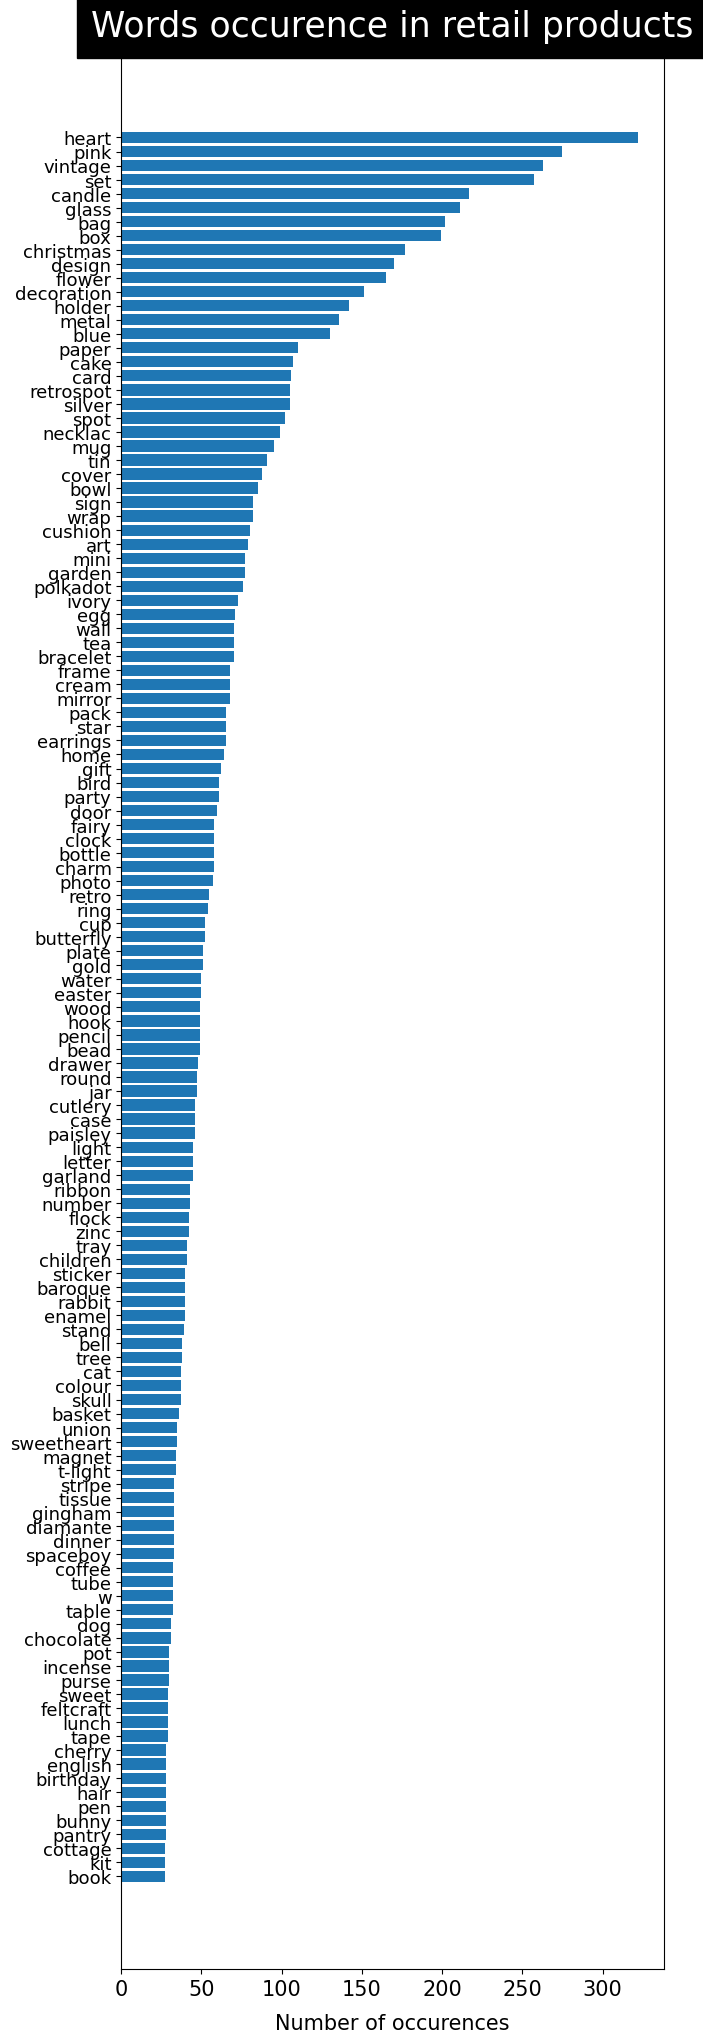

In [91]:
plt.rc('font', weight='normal')

fig, ax = plt.subplots(figsize=(7, 25))

# List 125 top items shown:
y_axis  = [i[1] for i in list_sorted[:125]]
x_axis  = [k for k,i in enumerate(list_sorted[:125])]
x_label = [i[0] for i in list_sorted[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel('Number of occurences', fontsize = 15, labelpad = 10)

ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title('Words occurence in retail products',
     bbox={'facecolor': 'k', 'pad': 5},
     color='w', fontsize = 25)
plt.show()

#### Insights:

Based on the graph above, we can see that the store has a handful of categories, with `heart`, `vintage`, `candle`, `glass`, `bag`, and `christmas` to name a top few (excluding colors).

### *"How can we group them all into clusters?"*

With the word occurence above, we could sense how we can group the products and customers into clusters. We can do that by making a columns of all words available, add rows of our available product, and assign the included word on each item (making a matrix), or one-hot encoding. We'll use it to create clusters using a machine learning of `KMeans`, and then visualize it using `WordCloud`.

In [92]:
list_products = []

for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange'] : continue
    if len(word) < 3 or v < 13                            : continue
    if ('+' in word) or ('/' in word)                     : continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x: x[1], reverse=True)
print('Preserved words: ', len(list_products))

Preserved words:  259


In [93]:
df_unique_products

,Description
0,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,PINK CHERRY LIGHTS
2,WHITE CHERRY LIGHTS
3,"RECORD FRAME 7"" SINGLE SIZE"
4,STRAWBERRY CERAMIC TRINKET BOX
...,...
5268,GIN AND TONIC DIET METAL SIGN
5269,SET OF 6 RIBBONS PARTY
5270,SILVER AND BLACK ORBIT NECKLACE
5271,CREAM HANGING HEART T-LIGHT HOLDER


In [94]:
# Tweaking format of `df_unique_products so that
# we can make a matrix out of it.
df_unique_products = combined_dfs['Description'].unique()

X = pd.DataFrame()

for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), df_unique_products))

In [95]:
X

,heart,vintage,set,candle,glass,bag,box,christmas,design,flower,...,soap,handbag,decoupage,candleholder,pocket,lampshade,plant,spring,wallet,point
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5269,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5271,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
pd.Series(list_products)[:15]

0          [heart, 322]
1        [vintage, 263]
2            [set, 257]
3         [candle, 217]
4          [glass, 211]
5            [bag, 202]
6            [box, 199]
7      [christmas, 177]
8         [design, 170]
9         [flower, 165]
10    [decoration, 151]
11        [holder, 142]
12         [metal, 136]
13         [paper, 110]
14          [cake, 107]
dtype: object

In [97]:
thres     = [0, 1, 2, 3, 5, 10]
label_col = []

# Label columns of price ranges:
for i in range(len(thres)):
    if i == len(thres) - 1:
        col = f'price > {thres[i]}'
    else:
        col = f'{thres[i]} < price < {thres[i+1]}'
    label_col.append(col)
    X.loc[:, col] = 0

In [98]:
# Assign 
for i, prod in enumerate(df_unique_products):
    price = combined_dfs.loc[
        combined_dfs['Description'] == prod, 'Price'].mean()
    j = 0
    while price > thres[j]:
        j += 1
        if j == len(thres): break
    X.loc[i, label_col[j-1]] = 1

In [99]:
X

,heart,vintage,set,candle,glass,bag,box,christmas,design,flower,...,plant,spring,wallet,point,0 < price < 1,1 < price < 2,2 < price < 3,3 < price < 5,5 < price < 10,price > 10
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5269,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5271,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [100]:
X.loc[:, label_col].sum()

0 < price < 1     1159
1 < price < 2     1400
2 < price < 3      936
3 < price < 5      855
5 < price < 10     675
price > 10         248
dtype: int64

### Creating Clusters of Products: KMeans

For clustering, we will use a machine learning model for clustering of `KMeans` or `K-Nearest Neighbors`. In short:
* the model clumps data into several groups randomly, 
* take the average of all points of each group, 
* reclump the data according to the nearest distance to each group,
* and repeat until you find the best settings.

To measure how many clusters are optimal for our dataset, we're using `silhouette_score`, portrayed in a range of `[-1, 1]`. 
* The score of `0` tells us that the sample is on or very close to the boundary between another cluster nearby.
* The closer the score is to `+1`, it tells us that the sample is the data are clustered well. 
* And vice-versa, the closer the score is to` -1`, itt ells us that the samples might have been assigned to the wrong clusters.

In [101]:
prod_matrix = X.to_numpy()

In [102]:
silh_score_prod = {}

for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(prod_matrix)
    clusters = kmeans.predict(prod_matrix)
    silhouette_avg = silhouette_score(prod_matrix, clusters)
    print(f'For n_clusters = {n_clusters}, the average silhouette is: {silhouette_avg}')
    silh_score_prod[n_clusters] = silhouette_avg

For n_clusters = 3, the average silhouette is: 0.09017772239163979
For n_clusters = 4, the average silhouette is: 0.10867484263312721
For n_clusters = 5, the average silhouette is: 0.11449686211427314
For n_clusters = 6, the average silhouette is: 0.13164453620505107
For n_clusters = 7, the average silhouette is: 0.12707596698396897
For n_clusters = 8, the average silhouette is: 0.12875101227986988
For n_clusters = 9, the average silhouette is: 0.12435847530311818


In [103]:
sort_silh_score_prod = sorted((v, k) for k, v in silh_score_prod.items())
n_clusters_prod = sort_silh_score_prod[-1][1]
silh_bound      = sort_silh_score_prod[-1][0] + 0.00125

silhouette_avg = -1
i = 0

while silhouette_avg < silh_bound:
    if i > 20: break
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters_prod, n_init=30)
    kmeans.fit(prod_matrix)
    clusters = kmeans.predict(prod_matrix)
    silhouette_avg = silhouette_score(prod_matrix, clusters)
    print(f'For n_clusters = {n_clusters_prod}, the average silhouette is: {silhouette_avg}')
    i += 1

For n_clusters = 6, the average silhouette is: 0.13055923774677736
For n_clusters = 6, the average silhouette is: 0.12807867373400872
For n_clusters = 6, the average silhouette is: 0.12812378240572855
For n_clusters = 6, the average silhouette is: 0.12902794116957297
For n_clusters = 6, the average silhouette is: 0.11348014484694868
For n_clusters = 6, the average silhouette is: 0.1350928465755625


In [104]:
pd.Series(clusters).value_counts()

2    1400
1    1159
4     936
3     855
5     675
0     248
Name: count, dtype: int64

### Silhouette Score Intra-Cluster

In [105]:
def graph_component_silhouette(n_clusters, lim_x, 
    mat_size, sample_silhouette_values, clusters):
    
    plt.rcParams['patch.force_edgecolor'] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor='dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregated the silhouette scores for 
        # samples of cluster i, and sort them.
        ith_cluster_sv = sample_silhouette_values[clusters == i]
        ith_cluster_sv.sort()
        
        size_cluster_i = ith_cluster_sv.shape[0]
        y_upper        = y_lower + size_cluster_i
        
        cmap  = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, 
            ith_cluster_sv, facecolor=color, edgecolor=color, alpha=0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, 
            str(i), color='red', fontweight='bold', bbox=dict(
                facecolor='black', boxstyle='round, pad=0.3'))
        
        # Define new graph boundary for new cluster
        y_lower = y_upper + 10

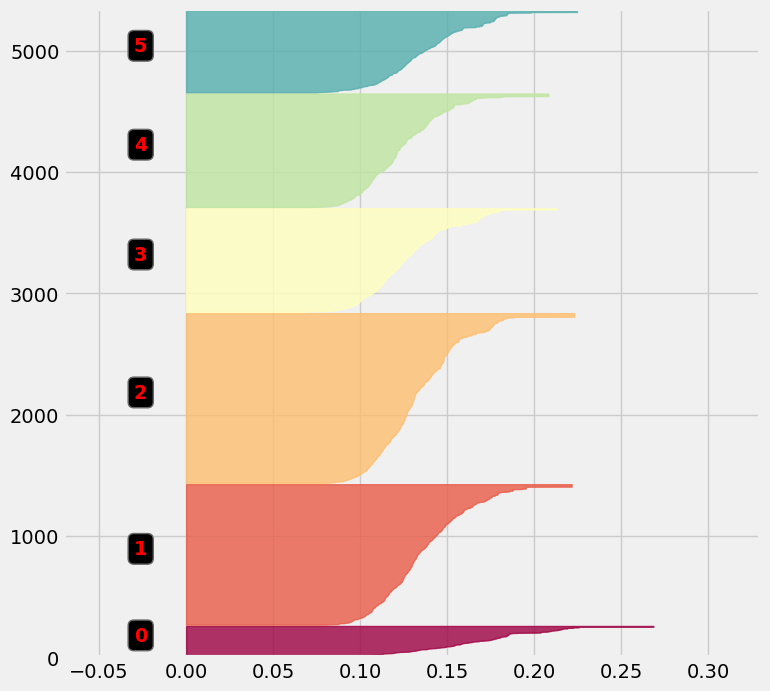

In [106]:
sample_silhouette_values = silhouette_samples(prod_matrix, clusters)

graph_component_silhouette(n_clusters_prod, [-0.07, 0.33], 
    len(X), sample_silhouette_values, clusters)

#### Characterizing the Content of Clusters: WordCloud

In [107]:
pd.DataFrame(df_unique_products).sample(10)

,0
5056,SET 36 COLOUR PENCILS LOVE LONDON
2790,CHERRY BLOSSOM PASSPORT COVER
3787,BLUE FAIRY CAKE CHILDRENS APRON
455,F FAIRY POTPOURRI CUSHIONS LAVENDER
4168,SET OF 6 HALLOWEEN GHOST T-LIGHTS
3189,ROUND GEORGIAN SILVER MIRROR
1346,VINTAGE PINK DECORATIVE PARASOL
4145,PINK POLKADOT CHILDRENS UMBRELLA
1683,MANHATTAN CANVAS ART PICTURE
5160,HENRIETTA HEN MUG


In [108]:
list_products[:10]

[['heart', 322],
 ['vintage', 263],
 ['set', 257],
 ['candle', 217],
 ['glass', 211],
 ['bag', 202],
 ['box', 199],
 ['christmas', 177],
 ['design', 170],
 ['flower', 165]]

In [109]:
df_unique_products

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'SILVER AND BLACK ORBIT NECKLACE',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [110]:
## CHECKPOINT: [36]

df_unique_products = pd.DataFrame(df_unique_products)
product_words = [word for (word, occ) in list_products]

occurence = [dict() for _ in range(n_clusters_prod)]

## The df compared: df_unique_products, but
## Where are the clusters of those??? Is it another df?

for i in range(n_clusters_prod):
    list_clusters = df_unique_products.loc[clusters == i]
    for word in product_words:
        if word in ['art', 'set', 'heart', 'pink', 
                    'blue', 'tag', 'ass']: continue
        occurence[i][word] = sum(list_clusters.loc[:, 0]
                                 .str.contains(word.upper()))

In [111]:
list_clusters

,0
0,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,PINK CHERRY LIGHTS
2,WHITE CHERRY LIGHTS
7,FANCY FONT HOME SWEET HOME DOORMAT
12,DOOR MAT BLACK FLOCK
...,...
5201,SWEETHEART WALL TIDY
5239,TUSCAN VILLA BIRD FEEDER
5252,IVORY RETRO KITCHEN WALL CLOCK
5255,BLUE RETRO KITCHEN WALL CLOCK


In [112]:
pd.DataFrame.from_dict(occurence)

,vintage,candle,glass,bag,box,christmas,design,flower,decoration,holder,...,soap,handbag,decoupage,candleholder,pocket,lampshade,plant,spring,wallet,point
0,25,1,12,3,15,2,4,4,0,2,...,0,0,0,0,0,1,2,0,0,0
1,39,57,25,40,22,92,44,48,84,39,...,0,0,5,4,7,9,0,7,13,3
2,61,86,55,80,45,53,65,60,46,50,...,4,4,2,3,8,4,3,6,0,0
3,48,47,45,26,45,15,16,36,2,21,...,0,2,2,0,0,1,7,0,0,6
4,57,72,50,76,57,23,38,43,18,34,...,7,9,4,5,0,2,6,0,0,0
5,41,15,51,11,36,7,6,24,0,13,...,1,3,0,1,0,0,6,0,0,7


In [113]:
def random_color_func(word=None, font_size=None, position=None,
    orientation=None, font_path=None, random_state=None):
    
    h = int(360.0 * tone  / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    
    return f'hsl({h}, {s}%, {l}%)'

def make_wordcloud(list_clusters, i):
    ax1 = fig.add_subplot(4, 2, i)
    words = dict()
    trunc_occ = list_clusters[:150]
    
    for s in trunc_occ:
        words[s[0]] = s[1]
        
    wordcloud = WordCloud(width=1000, height=400, 
                    background_color='lightgrey', max_words=1628, 
                    relative_scaling=1, color_func=random_color_func,
                    normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.axis('off')
    plt.title(f'Cluster {i-1}')

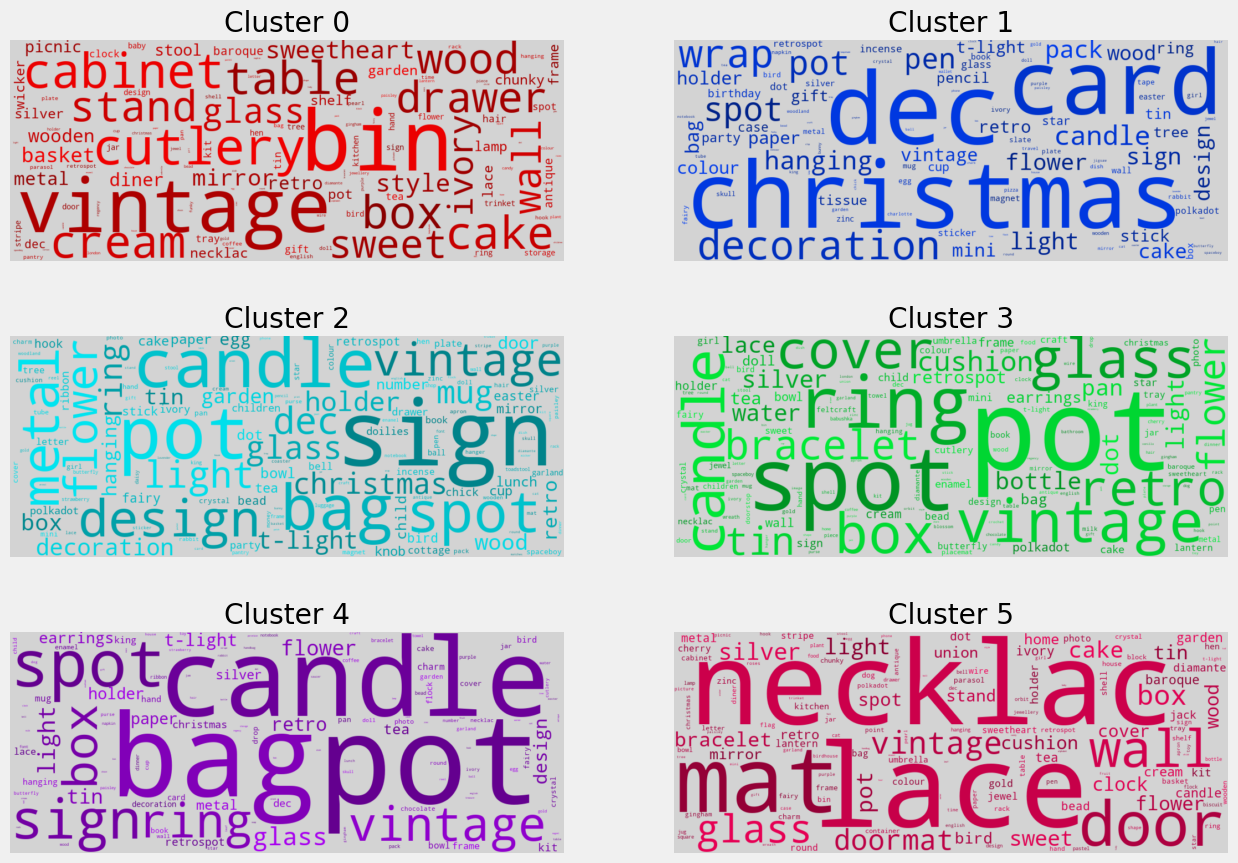

In [114]:
fig   = plt.figure(1, figsize=(14, 14))
color = [0, 160, 130, 95, 200, 240, 330, 110, 25]

for i in range(n_clusters_prod):
    list_cluster_occurences = occurence[i]

    tone = color[i] # Define the color of WordCloud
    list_words_per_cluster = []
    for key, value in list_cluster_occurences.items():
        list_words_per_cluster.append([key, value])
    
    list_words_per_cluster.sort(key = lambda x: x[1], reverse=True)
    make_wordcloud(list_words_per_cluster, i+1)

In [115]:
pd.Series(clusters).value_counts()

2    1400
1    1159
4     936
3     855
5     675
0     248
Name: count, dtype: int64

#### Insights:

We can see that each clusters have a theme going on; one being christmas, one being vintage, one being a specific object such as necklace or candle. 

### Principal Component Analysis (PCA): Clusters of Product

Even though we've clumped the products, our clusters could be related with each other. In this case, you may see vintage on more than one cluster. We can visualize the relations by transforming the data, and condense the large information into smaller number of new variables ('factors' or 'principal components') to picture the correlations. This is called Principal Component Analysis, a method we'll be using to visualize our clusters.

In [116]:
pca = PCA()
pca.fit(prod_matrix)
pca.samples = pca.transform(prod_matrix)

In [117]:
plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
%matplotlib inline

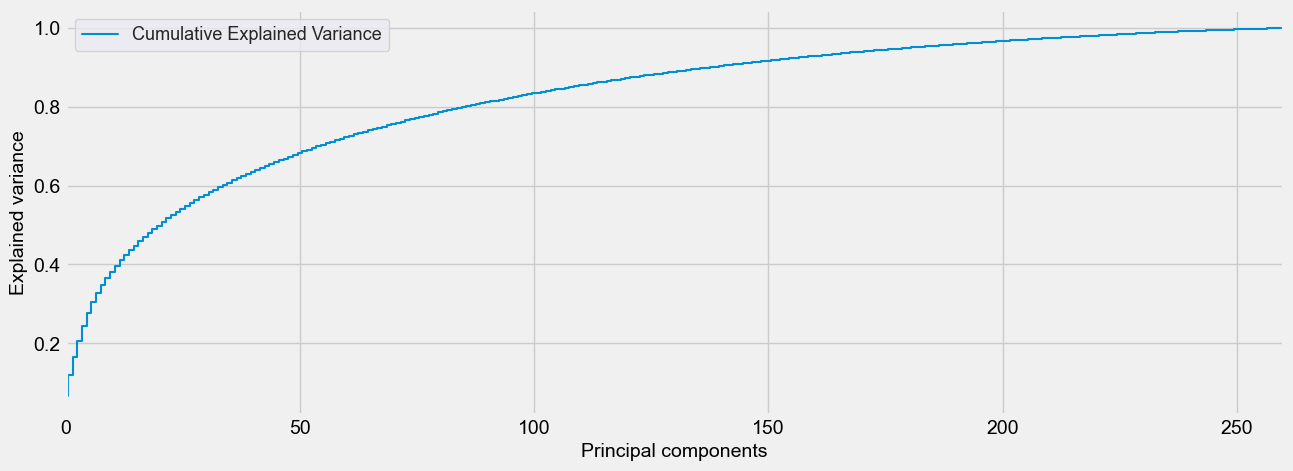

In [118]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.step(range(prod_matrix.shape[1]), pca.explained_variance_ratio_.cumsum(),
    where='mid', label='Cumulative Explained Variance')
# sns.barplot(range(1, prod_matrix.shape[1]+1), pca.explained_variance_ratio_,
#     alpha=0.5, color='g', label='Individual Explained Variance')
plt.xlim(0, 260)

ax.set_xticklabels(
    [s if int(s.get_text()) % 10 == 0
        else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance'  , fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.legend(loc='upper left', fontsize=13)

In [119]:
t = (pca.explained_variance_ratio_.cumsum() > 0.95)
idx_95 = np.array([i for i, x in enumerate(t) if x == True])
idx_95

array([181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264])

In [120]:
idx_95[0]

181

With a graph above, there's a following heuristic we can use to define the number of components in PCA. We're plotting explained variance ratio and choose a number of components that "capture" at least 95% of the variance. Here we take roughly 181 components.

In [121]:
pca = PCA(n_components=idx_95[0])
matrix_9D = pca.fit_transform(prod_matrix)

mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [122]:
mat

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,cluster
0,-0.151638,-0.215982,0.138827,0.506613,-0.899591,0.108928,1.170827,0.332845,0.117262,0.255074,...,-0.015555,-0.015785,-0.010516,-0.006492,-0.029957,0.034011,0.020448,0.028314,0.011965,5
1,-0.126787,-0.233073,0.179570,0.450401,-0.684437,0.280682,-0.081976,0.245635,-0.023516,0.645755,...,-0.011905,0.000216,-0.017802,-0.039468,-0.031555,-0.004953,-0.029033,-0.057261,0.022220,5
2,-0.126787,-0.233073,0.179570,0.450401,-0.684437,0.280682,-0.081976,0.245635,-0.023516,0.645755,...,-0.011905,0.000216,-0.017802,-0.039468,-0.031555,-0.004953,-0.029033,-0.057261,0.022220,5
3,-0.193195,-0.581071,-0.652677,-0.014791,0.081673,-0.168891,-0.084424,-0.111523,-0.148624,-0.011141,...,-0.017870,0.019804,0.001596,-0.031599,0.007736,0.059555,0.008719,-0.051267,-0.029354,4
4,0.775826,0.175155,-0.030397,-0.106333,-0.080369,-0.056247,-0.102978,-0.112799,-0.138690,-0.026043,...,-0.290865,0.188549,0.077920,0.012869,-0.149907,-0.022470,0.007441,-0.004785,-0.054849,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,-0.114306,-0.545572,-0.738637,-0.071628,0.065165,-0.228804,-0.206911,-0.496153,0.636108,0.177122,...,-0.011076,0.022590,-0.037253,-0.030751,0.039680,-0.017304,-0.010203,-0.055792,0.032585,4
5269,-0.136043,-0.456410,-0.651426,0.437475,0.651569,-0.050114,-0.232221,0.766015,0.350867,-0.357283,...,0.004000,0.005574,-0.021364,0.040237,-0.003177,-0.040087,0.027762,-0.000985,-0.024096,4
5270,-0.230390,-0.670557,-0.588423,0.087060,-0.117131,-0.120194,-0.035547,-0.011564,-0.164318,0.005398,...,-0.000631,0.072478,0.000138,-0.049131,0.110867,0.053901,-0.058541,-0.046637,-0.065418,4
5271,-0.188539,-0.323578,-0.691882,1.150699,1.033727,-0.058306,0.337624,0.520811,-0.034246,1.404635,...,-0.018513,0.030155,0.023827,-0.014741,-0.006355,0.009229,0.031614,-0.002883,-0.009181,4


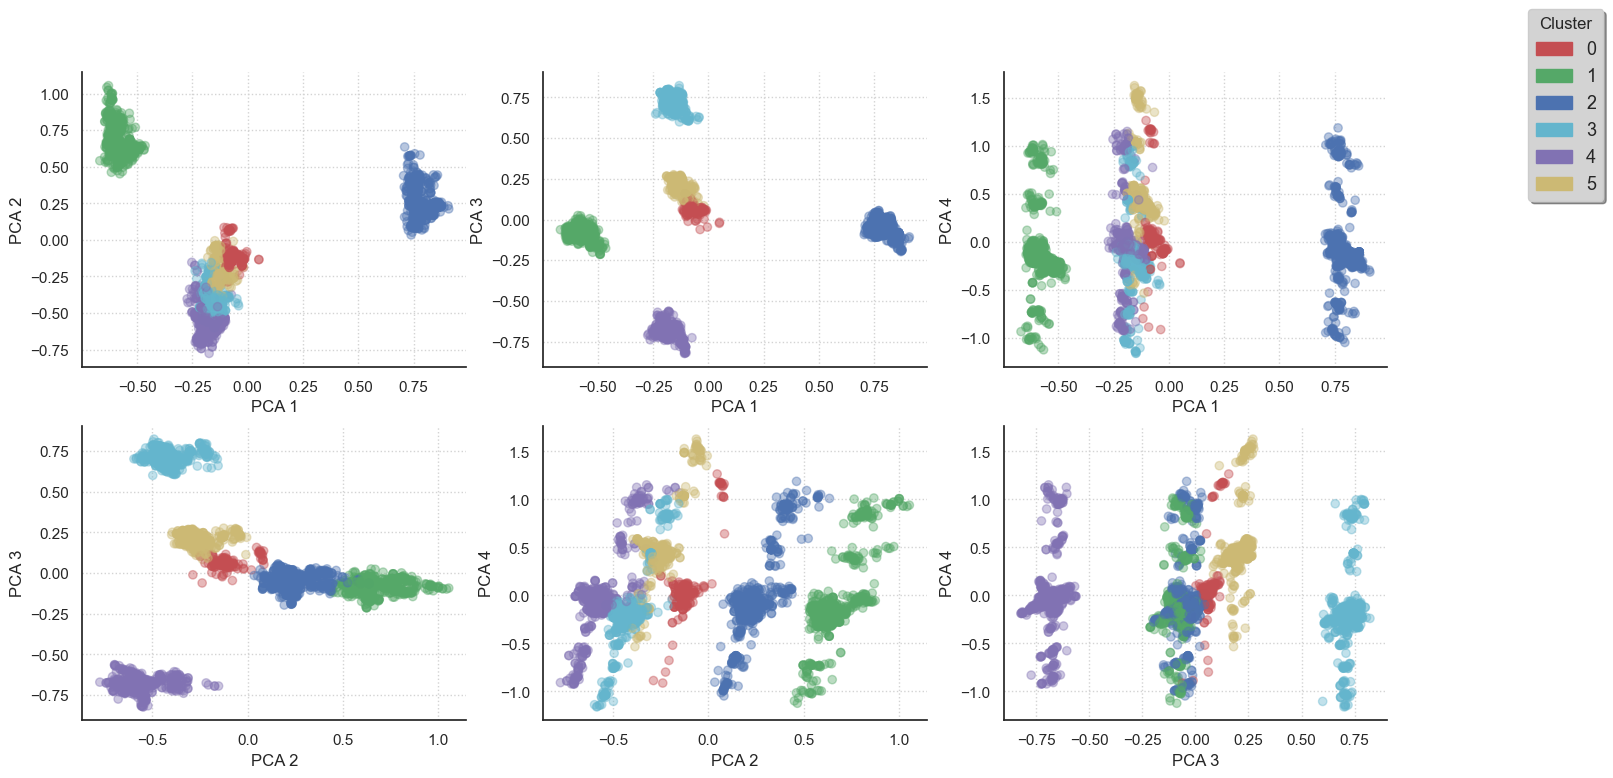

In [123]:
sns.set_style('white')
sns.set_context('notebook', font_scale=1,
    rc={'lines.linewidth': 2.5})

LABEL_COLOR_MAP = {
     0: 'r'        ,  1: 'g'      ,  2: 'b'       ,  3: 'c'       , 
     4: 'm'        ,  5: 'y'      ,  6: 'k'       ,  7: 'orange'  , 
     8: 'goldenrod',  9: 'lime'   , 10: 'skyblue' , 11: 'darkcyan', 
    12: 'indigo'   , 13: 'brown'  , 14: 'silver'  , 15: 'olive' 
}
label_color     = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15, 8))
i   = 0

for ix in range(4):
    for iy in range(ix+1, 4):
        
        i += 1
        ax = fig.add_subplot(2, 3, i)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        
        plt.xlabel(f'PCA {ix+1}', fontsize=12)
        plt.ylabel(f'PCA {iy+1}', fontsize=12)
        
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.yaxis.grid(color='lightgray', linestyle=':')
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if i == 9: break
    if i == 9: break
        

comp_handler = []

for i in range(n_clusters_prod):
    comp_handler.append(mpatches.Patch(
        color=LABEL_COLOR_MAP[i], label=i))
    
plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
    title='Cluster', facecolor='lightgrey', shadow=True,
    frameon=True, framealpha=1, fontsize=13, 
    bbox_transform=plt.gcf().transFigure)

plt.show()

#### Insights:

We can see that the clusters are well-grouped in several graphs, and not the other. This makes sense considering that we have silhouette score closer to 0 than 1, and good enough for our next part.

## Part 3: Customer Classification

With information of product clusters in our hands, we can now proceed into customer segmentation. The steps will be similar to product segmentation, with clustering and PCA, but we'll add another visualization and model predictions for the classification.

Before we go, we need to define what should be predicted in a customer. We'll utilize the product clusters, group the dataset per customer and bought item, and then group it again per customer further.

### Customer Categories

In [124]:
df_unique_products = combined_dfs['Description'].unique()

In [125]:
pd.Series(clusters)

0       5
1       5
2       5
3       4
4       2
       ..
5268    4
5269    4
5270    4
5271    4
5272    4
Length: 5273, dtype: int32

In [126]:
corresp = dict()

for key, val in zip(pd.Series(df_unique_products), pd.Series(clusters)):
    corresp[key] = val
    
combined_dfs['ctg_product'] = combined_dfs.loc[:, 'Description'].map(corresp)

In [127]:
pd.Series(corresp)[:20]

15CM CHRISTMAS GLASS BALL 20 LIGHTS    5
PINK CHERRY LIGHTS                     5
 WHITE CHERRY LIGHTS                   5
RECORD FRAME 7" SINGLE SIZE            4
STRAWBERRY CERAMIC TRINKET BOX         2
PINK DOUGHNUT TRINKET POT              2
SAVE THE PLANET MUG                    2
FANCY FONT HOME SWEET HOME DOORMAT     5
CAT BOWL                               4
DOG BOWL , CHASING BALL DESIGN         3
HEART MEASURING SPOONS LARGE           2
LUNCHBOX WITH CUTLERY FAIRY CAKES      4
DOOR MAT BLACK FLOCK                   5
LOVE BUILDING BLOCK WORD               5
HOME BUILDING BLOCK WORD               5
ASSORTED COLOUR BIRD ORNAMENT          2
 PEACE WOODEN BLOCK LETTERS            5
CHRISTMAS CRAFT WHITE FAIRY            2
HEART IVORY TRELLIS LARGE              2
HEART FILIGREE DOVE LARGE              2
dtype: int64

In [128]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue,ctg_product
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.0,83.40,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00,5
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00,5
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.0,100.80,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.0,30.00,2
...,...,...,...,...,...,...,...,...,...,...,...
782551,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20,1
782552,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60,4
782553,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,3
782554,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,3


In [129]:
for i in range(n_clusters_prod):
    col = f'ctg_{i}'
    df_temp = combined_dfs[combined_dfs['ctg_product'] == i]
    
    price_temp = df_temp['Price'] * (df_temp['Quantity'] + df_temp['cancelled_qty'])
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    
    combined_dfs.loc[:, col] = price_temp
    combined_dfs[col] = combined_dfs[col].fillna(0)

In [130]:
combined_dfs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_qty,revenue,ctg_product,ctg_0,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.0,83.40,5,0.0,0.0,0.0,0.00,0.0,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00,5,0.0,0.0,0.0,0.00,0.0,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.0,81.00,5,0.0,0.0,0.0,0.00,0.0,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.0,100.80,4,0.0,0.0,0.0,0.00,100.8,0.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.0,30.00,2,0.0,0.0,30.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782551,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20,1,0.0,10.2,0.0,0.00,0.0,0.0
782552,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60,4,0.0,0.0,0.0,0.00,12.6,0.0
782553,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,3,0.0,0.0,0.0,16.60,0.0,0.0
782554,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,3,0.0,0.0,0.0,16.60,0.0,0.0


In [131]:
pd.to_datetime(combined_dfs['InvoiceDate'])

0        2009-12-01 07:45:00
1        2009-12-01 07:45:00
2        2009-12-01 07:45:00
3        2009-12-01 07:45:00
4        2009-12-01 07:45:00
                 ...        
782551   2011-12-09 12:50:00
782552   2011-12-09 12:50:00
782553   2011-12-09 12:50:00
782554   2011-12-09 12:50:00
782555   2011-12-09 12:50:00
Name: InvoiceDate, Length: 765632, dtype: datetime64[ns]

In [132]:
basket_price = combined_dfs.groupby(['Customer ID', 'Invoice']).agg({
    'revenue': 'sum', 'InvoiceDate': lambda x: pd.to_datetime(x).mean()}
).reset_index().rename(columns={'revenue': 'basket_price'})

## Grouping clusters by `n_cluster_prod`
for n in range(n_clusters_prod):
    col = f'ctg_{n}' 
    basket_price.loc[:, col] = combined_dfs.groupby(
        ['Customer ID', 'Invoice']).agg({col: 'sum'}).reset_index()[col]

In [133]:
basket_price

,Customer ID,Invoice,basket_price,InvoiceDate,ctg_0,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5
0,12346.0,492722,1.00,2009-12-18 10:55:00.000000000,0.00,1.00,0.00,0.00,0.00,0.00
1,12346.0,499763,27.05,2010-03-02 13:08:00.000000000,0.00,0.00,0.00,3.25,0.00,23.80
2,12346.0,513774,142.31,2010-06-28 13:53:00.000000256,0.00,0.00,0.00,0.00,0.00,142.31
3,12346.0,541431,0.00,2011-01-18 10:01:00.000000000,0.00,0.00,0.00,0.00,0.00,0.00
4,12347.0,529924,611.53,2010-10-31 14:20:00.000000000,38.25,192.58,207.00,0.00,173.70,0.00
...,...,...,...,...,...,...,...,...,...,...
36560,18287.0,523290,30.60,2010-09-21 12:19:00.000000000,0.00,0.00,0.00,0.00,30.60,0.00
36561,18287.0,534346,331.50,2010-11-22 11:51:00.000000000,0.00,0.00,208.80,72.30,50.40,0.00
36562,18287.0,554065,725.68,2011-05-22 10:38:59.999999744,0.00,40.68,501.30,15.00,134.70,34.00
36563,18287.0,570715,1001.32,2011-10-12 10:22:59.999999744,0.00,219.40,423.88,32.00,326.04,0.00


In [134]:
basket_price.loc[basket_price['basket_price'] > 0].sort_values('Customer ID', ascending=True)

,Customer ID,Invoice,basket_price,InvoiceDate,ctg_0,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5
0,12346.0,492722,1.00,2009-12-18 10:55:00.000000000,0.0,1.00,0.00,0.00,0.00,0.00
1,12346.0,499763,27.05,2010-03-02 13:08:00.000000000,0.0,0.00,0.00,3.25,0.00,23.80
2,12346.0,513774,142.31,2010-06-28 13:53:00.000000256,0.0,0.00,0.00,0.00,0.00,142.31
11,12347.0,581180,224.82,2011-12-07 15:52:00.000000000,0.0,38.58,77.40,23.40,55.44,30.00
10,12347.0,573511,1294.32,2011-10-31 12:25:00.000000256,76.5,145.30,200.60,392.12,424.20,55.60
...,...,...,...,...,...,...,...,...,...,...
36560,18287.0,523290,30.60,2010-09-21 12:19:00.000000000,0.0,0.00,0.00,0.00,30.60,0.00
36561,18287.0,534346,331.50,2010-11-22 11:51:00.000000000,0.0,0.00,208.80,72.30,50.40,0.00
36562,18287.0,554065,725.68,2011-05-22 10:38:59.999999744,0.0,40.68,501.30,15.00,134.70,34.00
36563,18287.0,570715,1001.32,2011-10-12 10:22:59.999999744,0.0,219.40,423.88,32.00,326.04,0.00


### Time-Series Dataset: Training and Test

For our classification, we'll divide the data to two parts: training set (80%) and test set (20%). We'll put a threshold date of `2011-07-14` to separate both sets.

In [135]:
last_date = pd.to_datetime(combined_dfs['InvoiceDate'].max())
last_date

Timestamp('2011-12-09 12:50:00')

In [136]:
date_thres = pd.to_datetime('2011-07-14')

basket_price = basket_price.loc[basket_price['basket_price'] > 0]

train = basket_price.loc[basket_price['InvoiceDate'] <= date_thres]
test  = basket_price.loc[basket_price['InvoiceDate']  > date_thres]

basket_price = train.copy(deep = True)

In [137]:
test

,Customer ID,Invoice,basket_price,InvoiceDate,ctg_0,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5
9,12347.0,562032,584.91,2011-08-02 08:48:00.000000000,38.25,61.30,109.70,158.16,119.70,97.80
10,12347.0,573511,1294.32,2011-10-31 12:25:00.000000256,76.50,145.30,200.60,392.12,424.20,55.60
11,12347.0,581180,224.82,2011-12-07 15:52:00.000000000,0.00,38.58,77.40,23.40,55.44,30.00
16,12348.0,568172,270.00,2011-09-25 13:13:00.000000000,0.00,0.00,270.00,0.00,0.00,0.00
19,12349.0,577609,1454.60,2011-11-21 09:51:00.000000000,150.50,79.32,477.56,188.30,200.57,358.35
...,...,...,...,...,...,...,...,...,...,...
36551,18283.0,578262,298.57,2011-11-23 13:27:00.000000512,0.00,59.56,111.08,0.00,127.93,0.00
36552,18283.0,579673,195.46,2011-11-30 12:58:59.999999744,0.00,26.25,75.87,9.75,83.59,0.00
36553,18283.0,580872,208.00,2011-12-06 12:02:00.000000256,0.00,27.07,93.10,0.00,87.83,0.00
36563,18287.0,570715,1001.32,2011-10-12 10:22:59.999999744,0.00,219.40,423.88,32.00,326.04,0.00


### Consumer Order Combinations

Now we have all list of customers and their transactions, we can group them further per customer to get the data we need for segmentation.

In [138]:
transactions_per_user = basket_price.groupby(['Customer ID']).agg({
    'basket_price': ['count', 'min', 'max', 'mean', 'sum']})
transactions_per_user.columns = [f'bp_{i[1]}' for i in
    transactions_per_user.columns.to_flat_index()]

for i in range(n_clusters_prod):
    ## Calculate percentage of sales in each category
    col = f'ctg_{i}'
    transactions_per_user.loc[:, f'pct_{col}'] = (
        basket_price.groupby(['Customer ID'])[col].sum() /
        transactions_per_user['bp_sum'] * 100)
    
# Adding days since first purchase and last purchase
time_of_purchase = basket_price.groupby(['Customer ID']).agg(
    first_purchase = ('InvoiceDate', lambda x: (last_date - x.min()).days),
     last_purchase = ('InvoiceDate', lambda x: (last_date - x.max()).days)
)
transactions_per_user = pd.concat([transactions_per_user, time_of_purchase], axis=1)
    
transactions_per_user = transactions_per_user.reset_index()
transactions_per_user.sort_values('Customer ID', ascending=True)[:5]
transactions_per_user

,Customer ID,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,first_purchase,last_purchase
0,12346.0,3,1.00,142.31,56.786667,170.36,0.000000,0.586992,0.000000,1.907725,0.000000,97.505283,721,528
1,12347.0,5,382.52,711.79,563.496000,2817.48,4.072788,15.003478,33.008220,26.488564,16.303931,5.123018,403,182
2,12348.0,4,187.44,451.20,296.700000,1186.80,0.000000,53.353556,46.646444,0.000000,0.000000,0.000000,437,248
3,12349.0,2,1064.77,1150.12,1107.445000,2214.89,15.637345,9.210390,26.976509,7.354767,10.673216,30.147773,588,407
4,12350.0,1,294.40,294.40,294.400000,294.40,0.000000,13.281250,55.027174,0.000000,31.691576,0.000000,309,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,18283.0,13,32.20,168.28,106.717692,1387.33,2.353442,13.473363,40.440270,10.228280,24.400827,9.103818,657,168
5032,18284.0,1,411.68,411.68,411.680000,411.68,0.000000,50.179751,13.772833,15.060241,20.987175,0.000000,431,431
5033,18285.0,1,377.00,377.00,377.000000,377.00,7.931034,4.774536,8.912467,5.251989,54.111406,19.018568,660,660
5034,18286.0,2,358.95,833.48,596.215000,1192.43,11.472372,14.134163,27.691353,9.581275,17.032446,20.088391,723,476


In [139]:
n1 = transactions_per_user.loc[transactions_per_user['bp_count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]

print(f'Number of single-purchase customers: {n1}/{n2} ({n1/n2*100:.4f}%)')

Number of single-purchase customers: 1542/5036 (30.6195%)


### Customers Clustering

In [140]:
list_cols = transactions_per_user.columns[1:-2]
list_cols

Index(['bp_count', 'bp_min', 'bp_max', 'bp_mean', 'bp_sum', 'pct_ctg_0',
       'pct_ctg_1', 'pct_ctg_2', 'pct_ctg_3', 'pct_ctg_4', 'pct_ctg_5'],
      dtype='object')

In [141]:
selected_customers = transactions_per_user.copy(deep = True)
cust_matrix = selected_customers[list_cols].to_numpy()

In [142]:
scaler = StandardScaler()
scaler.fit(cust_matrix)
scaled_matrix = scaler.transform(cust_matrix)

In [143]:
pd.DataFrame(data=scaler.mean_, index=list_cols, columns=['mean'])

,mean
bp_count,5.402701
bp_min,216.357951
bp_max,584.406391
bp_mean,356.142743
bp_sum,2374.912286
pct_ctg_0,6.800577
pct_ctg_1,14.209290
pct_ctg_2,27.767062
pct_ctg_3,15.825534
pct_ctg_4,19.141123


In [144]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

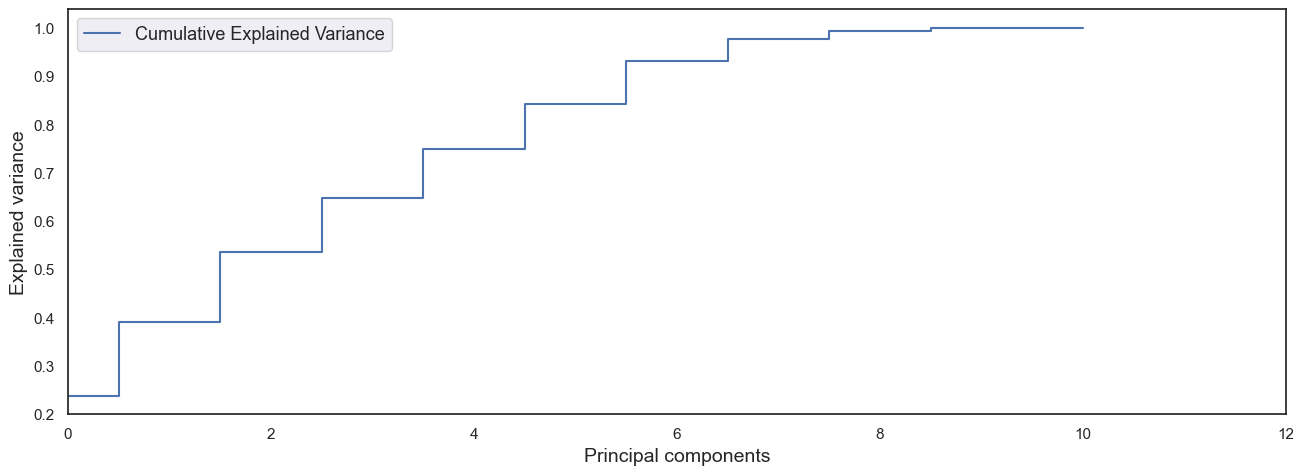

In [145]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.step(range(cust_matrix.shape[1]), pca.explained_variance_ratio_.cumsum(),
    where='mid', label='Cumulative Explained Variance')
# sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_,
#     alpha=0.5, color='g', label='Individual Explained Variance')
plt.xlim(0, 12)

plt.xlabel('Principal components', fontsize=14)
plt.ylabel('Explained variance', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.show()

In [146]:
t = (pca.explained_variance_ratio_.cumsum() > 0.95)
idx_95 = np.array([i for i, x in enumerate(t) if x == True])
idx_95

array([ 7,  8,  9, 10])

In [147]:
idx_95[0]

7

In [148]:
silh_score_cust = {}

for n_clusters in range(3, 16):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print(f'For n_clusters = {n_clusters}, the average silhouette is: {silhouette_avg}')
    silh_score_cust[n_clusters] = silhouette_avg

For n_clusters = 3, the average silhouette is: 0.15235049838563053
For n_clusters = 4, the average silhouette is: 0.15504053391706982
For n_clusters = 5, the average silhouette is: 0.13743862149382297
For n_clusters = 6, the average silhouette is: 0.13969091401649836
For n_clusters = 7, the average silhouette is: 0.16428889000647726
For n_clusters = 8, the average silhouette is: 0.15569827321678206
For n_clusters = 9, the average silhouette is: 0.17362431730500635
For n_clusters = 10, the average silhouette is: 0.19341120413661897
For n_clusters = 11, the average silhouette is: 0.1964362706190869
For n_clusters = 12, the average silhouette is: 0.20230657560452542
For n_clusters = 13, the average silhouette is: 0.17656778001643453
For n_clusters = 14, the average silhouette is: 0.17730503391706948
For n_clusters = 15, the average silhouette is: 0.17715165337856964


In [149]:
sort_silh_score_cust = sorted((v, k) for k, v in silh_score_cust.items())

## We're taking second highest-value here given that
## in several experiments, the highest silhouette score is in
## clusters of 3. We need to visualize each 6 product clusters
## so we're going to take the next option.
n_clusters_cust = sort_silh_score_cust[-2][1]
silh_bound      = sort_silh_score_cust[-2][0] + 0.00125

silhouette_avg = -1
i = 0

while silhouette_avg < silh_bound:
    if i > 20: break
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters_cust, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print(f'For n_clusters = {n_clusters_cust}, the average silhouette is: {silhouette_avg}')
    i += 1

For n_clusters = 11, the average silhouette is: 0.19607994589061248
For n_clusters = 11, the average silhouette is: 0.19575436488435322
For n_clusters = 11, the average silhouette is: 0.19729992310791475
For n_clusters = 11, the average silhouette is: 0.1966487737459487
For n_clusters = 11, the average silhouette is: 0.19753947980884318
For n_clusters = 11, the average silhouette is: 0.19834432696276472


In [150]:
pd.Series(clusters).value_counts().sort_index()

0      541
1      237
2      175
3        6
4        5
5     2396
6       32
7      258
8      722
9      236
10     428
Name: count, dtype: int64

### PCA: Clusters of Customers

In [151]:
pca_cust  = PCA(n_components=idx_95[0])
matrix_3D = pca.fit_transform(scaled_matrix)
mat_cust  = pd.DataFrame(matrix_3D)
mat_cust['cluster'] = pd.Series(clusters)

In [152]:
mat_cust

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,-0.794523,-3.419373,1.049007,-1.767575,-1.509177,-0.160996,-3.805610,-0.307189,-0.000953,0.038304,4.569134e-15,0
1,0.404624,0.573820,0.278497,0.303174,0.812050,-0.422313,0.319225,0.109810,0.034865,-0.069045,-2.126519e-15,5
2,-0.369691,2.483235,-1.007297,-1.986304,0.823425,0.702088,-0.379145,0.011106,-0.011936,0.018965,-3.242819e-15,9
3,1.622075,0.191813,2.158752,-1.067291,-0.839389,-0.278923,-0.063974,0.441047,0.260503,0.106306,-6.685506e-16,2
4,-0.354961,1.923928,-0.556122,0.626989,-1.172019,-0.333297,0.285519,-0.074483,0.204754,0.089410,-1.550110e-15,8
...,...,...,...,...,...,...,...,...,...,...,...,...
5031,-0.409963,0.452253,-1.147376,0.364938,-0.363183,-0.216334,0.029923,0.523740,-0.145047,0.050171,-1.179042e-16,5
5032,-0.144046,1.508075,0.186704,-0.276250,1.277522,2.034585,-0.133348,0.045355,0.200021,0.082964,5.454885e-16,9
5033,-0.068900,-0.375511,0.679685,1.833941,-1.675273,1.467854,0.247184,-0.060243,0.238668,0.081636,1.491485e-16,10
5034,0.320640,0.121207,0.600696,-0.483995,-0.453224,0.067306,0.090882,-0.153420,-0.076129,-0.087460,1.218231e-16,5


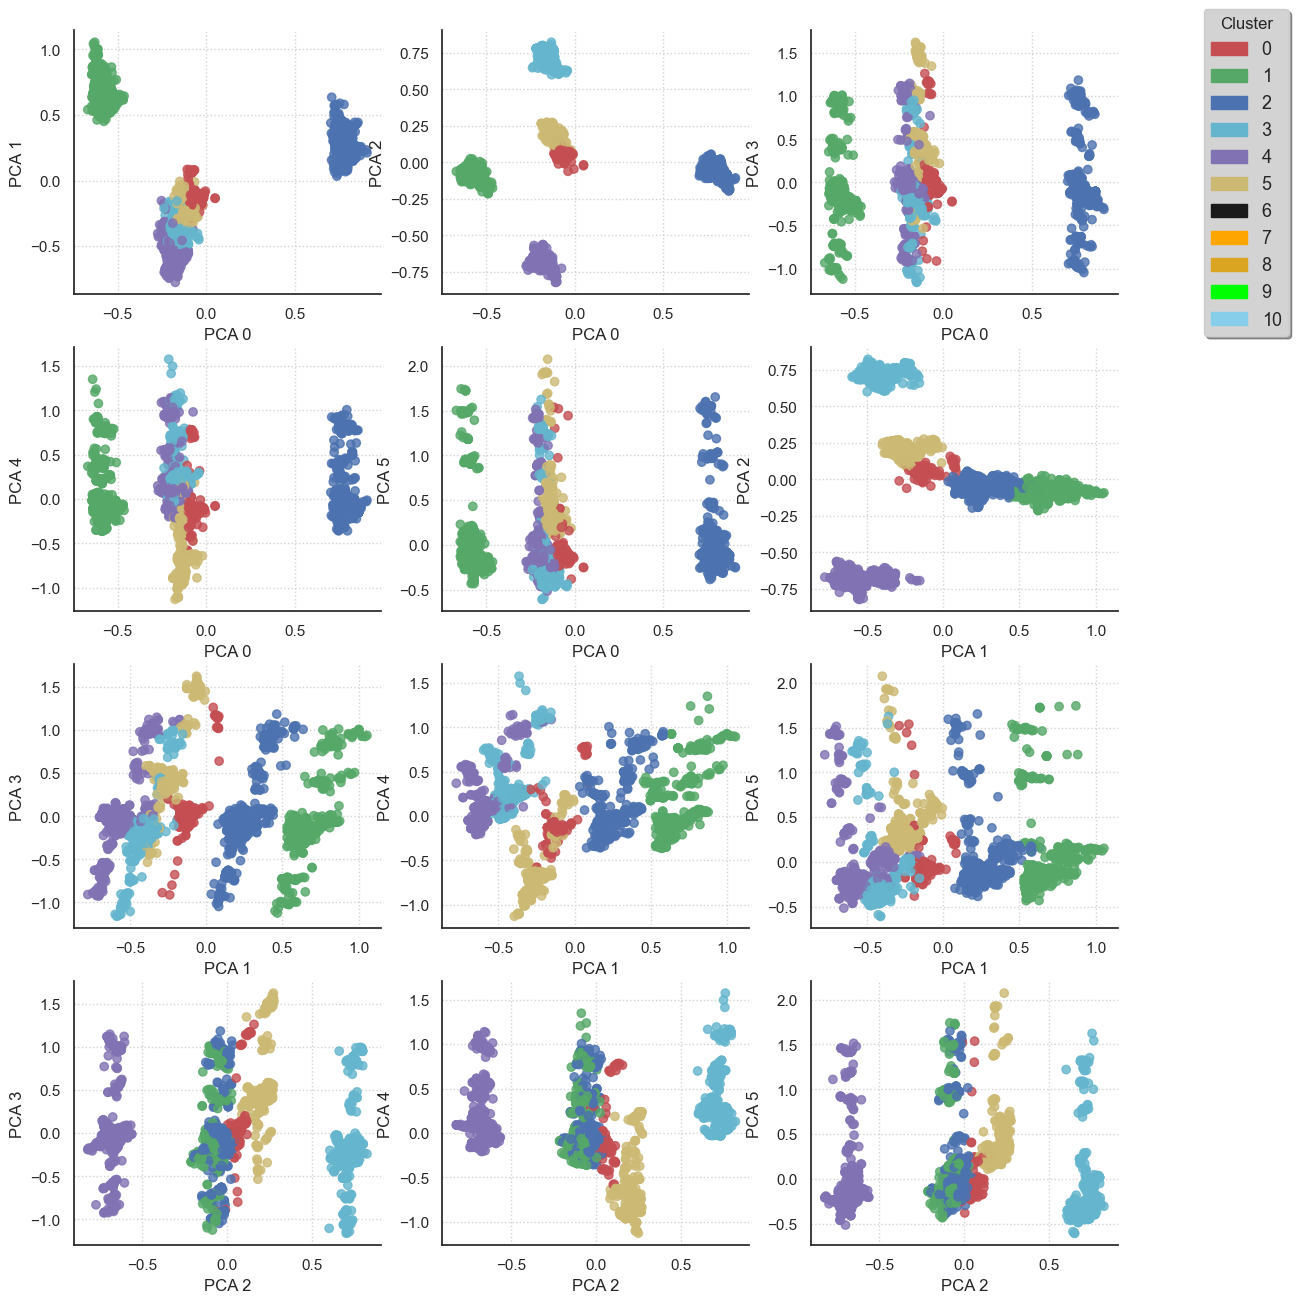

In [153]:
sns.set_style('white')
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 2.5})

LABEL_COLOR_MAP = {
     0: 'r'        ,  1: 'g'      ,  2: 'b'       ,  3: 'c'       , 
     4: 'm'        ,  5: 'y'      ,  6: 'k'       ,  7: 'orange'  , 
     8: 'goldenrod',  9: 'lime'   , 10: 'skyblue' , 11: 'darkcyan', 
    12: 'indigo'   , 13: 'brown'  , 14: 'silver'  , 15: 'olive' 
}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize=(12, 15))

i = 0

for ix in range(6):
    for iy in range(ix+1, 6):

        i += 1
        
        ax = fig.add_subplot(4, 3, i)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.8)
        
        plt.xlabel(f'PCA {ix}', fontsize=12)
        plt.ylabel(f'PCA {iy}', fontsize=12)
        
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.yaxis.grid(color='lightgray', linestyle=':')
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if i == 12: break
    if i == 12: break
        
comp_handler = []
for i in range(n_clusters_cust):
    comp_handler.append(mpatches.Patch(
        color=LABEL_COLOR_MAP[i], label = i))
    
plt.legend(handles = comp_handler, bbox_to_anchor = (1.1, 0.9),
    title = 'Cluster', facecolor = 'lightgrey', shadow = True,
    framealpha = 1, fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

### Silhouette Score Intra-Cluster

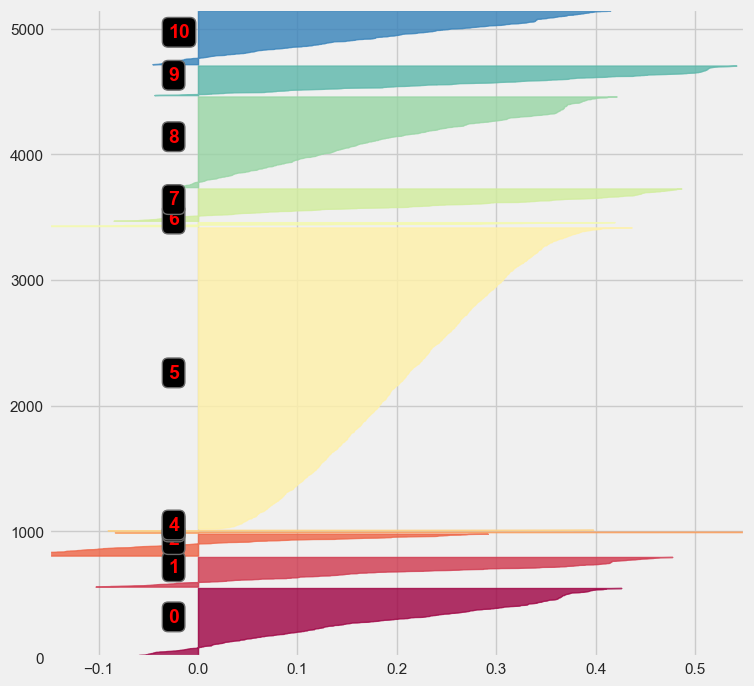

In [154]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters)

graph_component_silhouette(n_clusters_cust, [-0.15, 0.55],
    len(scaled_matrix), sample_silhouette_values, clusters)

### Customers' Morphotype

Now we have both clusters of products and customers, we can look for the percentages by making a visualization of RadarChart.

In [155]:
selected_customers.loc[:, 'cluster'] = clusters

In [156]:
selected_customers.dtypes

Customer ID       float64
bp_count            int64
bp_min            float64
bp_max            float64
bp_mean           float64
bp_sum            float64
pct_ctg_0         float64
pct_ctg_1         float64
pct_ctg_2         float64
pct_ctg_3         float64
pct_ctg_4         float64
pct_ctg_5         float64
first_purchase      int64
last_purchase       int64
cluster             int32
dtype: object

In [157]:
selected_customers

,Customer ID,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,first_purchase,last_purchase,cluster
0,12346.0,3,1.00,142.31,56.786667,170.36,0.000000,0.586992,0.000000,1.907725,0.000000,97.505283,721,528,0
1,12347.0,5,382.52,711.79,563.496000,2817.48,4.072788,15.003478,33.008220,26.488564,16.303931,5.123018,403,182,5
2,12348.0,4,187.44,451.20,296.700000,1186.80,0.000000,53.353556,46.646444,0.000000,0.000000,0.000000,437,248,9
3,12349.0,2,1064.77,1150.12,1107.445000,2214.89,15.637345,9.210390,26.976509,7.354767,10.673216,30.147773,588,407,2
4,12350.0,1,294.40,294.40,294.400000,294.40,0.000000,13.281250,55.027174,0.000000,31.691576,0.000000,309,309,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,18283.0,13,32.20,168.28,106.717692,1387.33,2.353442,13.473363,40.440270,10.228280,24.400827,9.103818,657,168,5
5032,18284.0,1,411.68,411.68,411.680000,411.68,0.000000,50.179751,13.772833,15.060241,20.987175,0.000000,431,431,9
5033,18285.0,1,377.00,377.00,377.000000,377.00,7.931034,4.774536,8.912467,5.251989,54.111406,19.018568,660,660,10
5034,18286.0,2,358.95,833.48,596.215000,1192.43,11.472372,14.134163,27.691353,9.581275,17.032446,20.088391,723,476,5


In [158]:
merged_df = pd.DataFrame()

for i in range(n_clusters_cust):
    temp = pd.DataFrame(selected_customers.loc[
        selected_customers['cluster'] == i].mean())
    temp = temp.T.set_index('cluster', drop=True)
    temp['size'] = selected_customers.loc[
        selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, temp])
    
merged_df = merged_df.drop(columns='Customer ID')
print(f"Number of customers: {merged_df['size'].sum()}")

merged_df = merged_df.sort_values('cluster')

Number of customers: 5036


In [159]:
merged_df

,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,first_purchase,last_purchase,size
cluster,,,,,,,,,,,,,,
0.0,3.852126,189.522200,371.062089,270.581463,1122.163290,7.103854,5.139250,12.767389,12.768758,12.661892,49.558857,525.203327,355.780037,541
1.0,3.759494,171.033924,352.538143,251.561876,1075.334093,48.058329,5.492468,12.304839,11.215178,9.247748,13.681438,505.586498,366.991561,237
2.0,4.748571,914.958634,2344.982863,1444.282152,6654.235097,6.745358,14.097910,28.679842,14.290965,20.856723,15.329201,524.628571,347.977143,175
3.0,1.666667,8547.908333,10846.428333,9651.686111,14512.928333,1.701067,11.768950,17.675223,23.628902,26.561557,18.664300,415.666667,335.833333,6
4.0,71.400000,30.420000,28788.674000,4351.102631,248971.256000,7.086598,8.134465,24.125069,18.079665,20.671095,21.903107,635.200000,156.200000,5
5.0,6.169449,178.546954,544.214822,331.901925,2164.810300,5.832313,14.416824,27.493038,17.031018,19.847609,15.379198,558.329716,301.092237,2396
6.0,93.250000,25.020000,4065.862531,741.491209,56627.583188,8.207736,10.067916,27.168940,15.934284,21.566823,17.054302,732.750000,167.500000,32
7.0,3.244186,179.913256,380.840194,262.379738,1127.939070,2.919802,5.776096,12.639183,57.904065,11.466029,9.294825,528.759690,386.236434,258
8.0,3.367036,193.982396,374.606579,275.826657,1037.313712,1.911765,13.896182,57.861318,7.434442,12.951211,5.945082,502.044321,349.391967,722


In [160]:
merged_df.loc[merged_df['pct_ctg_0'] > 35].index

Index([1.0], dtype='float64', name='cluster')

In [161]:
## Make a DataFrame of clusters who has a large majority 
## in a single category (threshold: 45%), and then
## followed by other clusters below (for data-viz purposes)

list_index = []
for i in range(n_clusters_prod):
    col = f'pct_ctg_{i}'
    list_index.append(merged_df.loc[
        merged_df[col] > 35].index.values[0])
    
list_index_reordered  = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index ]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop=False)
merged_df[merged_df.columns.drop(['first_purchase', 'last_purchase'])]

,cluster,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,size
0,1.0,3.759494,171.033924,352.538143,251.561876,1075.334093,48.058329,5.492468,12.304839,11.215178,9.247748,13.681438,237
1,9.0,2.580508,193.681822,342.573559,259.490425,709.016822,1.257972,63.168336,18.586375,5.326273,7.719309,3.941735,236
2,8.0,3.367036,193.982396,374.606579,275.826657,1037.313712,1.911765,13.896182,57.861318,7.434442,12.951211,5.945082,722
3,7.0,3.244186,179.913256,380.840194,262.379738,1127.939070,2.919802,5.776096,12.639183,57.904065,11.466029,9.294825,258
4,10.0,3.252336,173.303320,363.934862,252.499587,923.934278,2.619779,8.415020,20.093414,10.556704,49.216041,9.099043,428
5,0.0,3.852126,189.522200,371.062089,270.581463,1122.163290,7.103854,5.139250,12.767389,12.768758,12.661892,49.558857,541
6,2.0,4.748571,914.958634,2344.982863,1444.282152,6654.235097,6.745358,14.097910,28.679842,14.290965,20.856723,15.329201,175
7,3.0,1.666667,8547.908333,10846.428333,9651.686111,14512.928333,1.701067,11.768950,17.675223,23.628902,26.561557,18.664300,6
8,4.0,71.400000,30.420000,28788.674000,4351.102631,248971.256000,7.086598,8.134465,24.125069,18.079665,20.671095,21.903107,5
9,5.0,6.169449,178.546954,544.214822,331.901925,2164.810300,5.832313,14.416824,27.493038,17.031018,19.847609,15.379198,2396


## Customer Morphology

description

In [162]:
## typos: check. none.

def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d        = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1
            for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    
    def __init__(self, fig, location, sizes, 
        variables, ranges, n_ordinate_levels=6):
        
        angles = np.arange(0, 360, 360./len(variables))
        
        ix, iy         = location[:]
        size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], 
                polar=True, label= f'axes{i}')
            for i in range(len(variables))] #check
        
        _, text = axes[0].set_thetagrids(angles, labels=variables) ## ????
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle -  90)
            else:
                txt.set_rotation(angle - 270)
                
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid('off')
         
        # test
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)   # check
            grid_label = [''] + [f'{x:.0f}' for x in grid[1:-1]] + [''] # check
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i]) # ???? ANGLES!
            ax.set_ylim(*ranges[i])
            
        self.angle  = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax     = axes[0]
        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        
    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

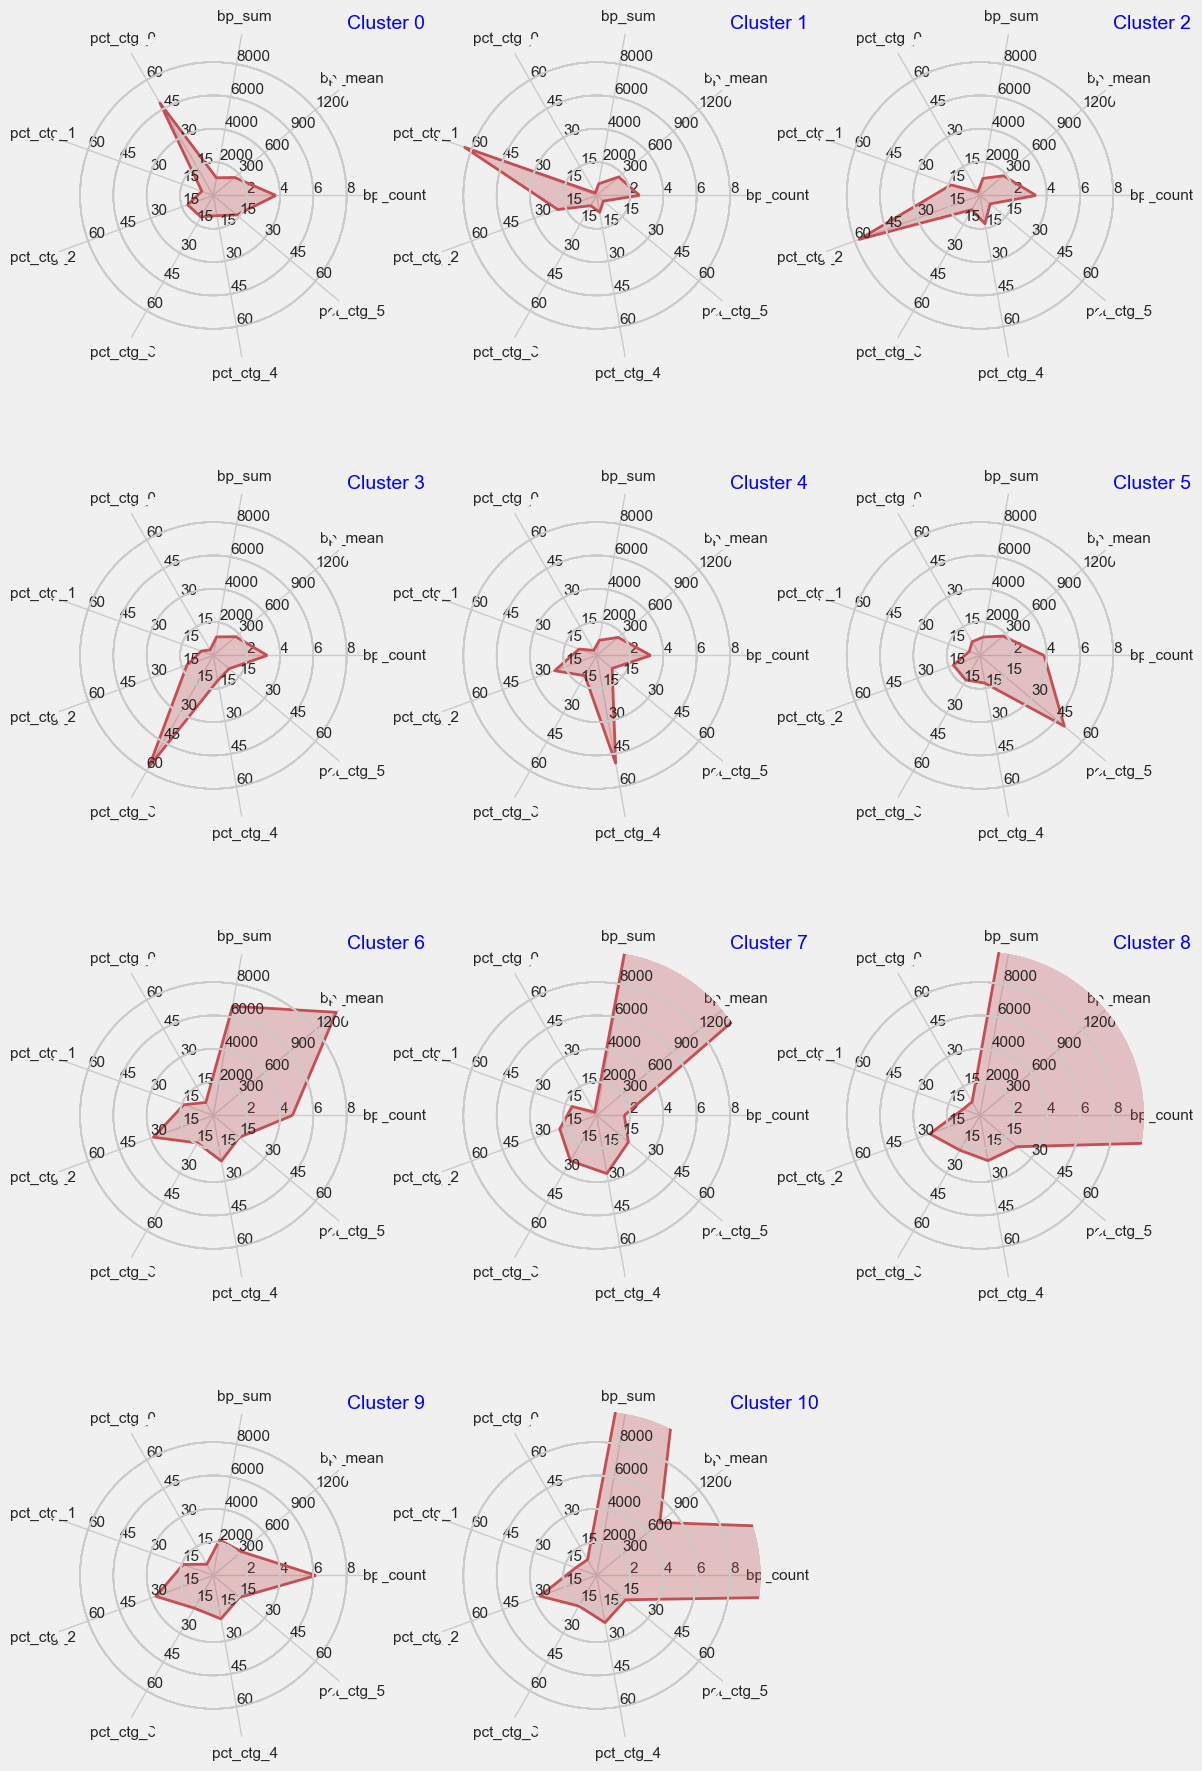

In [163]:
fig = plt.figure(figsize=(10, 12))

attributes = [
     'bp_count',    'bp_mean',     'bp_sum', 
    'pct_ctg_0',  'pct_ctg_1',  'pct_ctg_2',
    'pct_ctg_3',  'pct_ctg_4',  'pct_ctg_5'
]

ranges = [ 
     [0.01, 10], [0.01, 1500], [0.01, 10000],
     [0.01, 75], [0.01,   75], [0.01,    75],
     [0.01, 75], [0.01,   75], [0.01,    75]
]

index = [
     0,  1,  2,  3,
     4,  5,  6,  7,
     8,  9, 10, 11,
    12, 13, 14, 15
]

n_groups = n_clusters_cust
i_cols   = 3
i_rows   = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters_cust):
    
    ix = ind % 3
    iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [ pos_x,  pos_y]
    sizes    = [size_x, size_y]
    
    data  = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, 
        attributes, ranges, n_ordinate_levels=6)
    radar.plot(data, color='r', linewidth=2.0)
    radar.fill(data, alpha=0.3, color='r')
    radar.title(title=f'Cluster {index[ind]}', color='blue')
    ind += 1

### Customer Classification

With our data in hand, now we can proceed into customer classification. We'll use several machine learning models, with an addition of confusion matrix to check our data imbalances and also learning curve in each model to visualize the model's accuracy overtime.

In [164]:
class Class_Fit(object):
    
    def __init__(self, clf, params=None):
        if params: self.clf = clf(**params)
        else     : self.clf = clf()
                    
    def train(self, x_train, y_train):
        self.clt.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf,
            param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        self.accuracy    = accuracy_score(Y, self.predictions)
        print(f'Accuracy: {self.accuracy * 100:.4f}%')

In [165]:
cols = ['bp_mean'] + [f'pct_ctg_{i}' for i in range(n_clusters_prod)]
X = selected_customers[cols]
y = selected_customers['cluster']

In [166]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)

### Confusion Matrix

In [167]:
def plot_confusion_matrix(cm, classes, normalize=False, 
    title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confustion Matrix, without Normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(
        range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment = 'center',
            color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

#### Insights:

As we can see, there are several rows/columns with 0 all across the places. This makes sense since some clusters have less data compared to others.

### Learning Curve

In [168]:
def plot_learning_curve(estimator, title, X, y, 
    ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generating a simple plot of the test and training learning curve"""
    
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    val_scores_mean  = np.mean(val_scores, axis=1)
    val_scores_std   = np.std(val_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, 
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha = 0.1, color = 'r')
    
    plt.fill_between(train_sizes, 
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha = 0.1, color = 'g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', 
        color='r', label = 'Training score')
    plt.plot(train_sizes,   val_scores_mean, 'o-', 
        color='g', label = 'Cross-validation score')
    plt.legend(loc='best')
    return plt

In [169]:
classifier_names = [
    'Support Vector Machine', 'Logistic Regression', 'K-Nearest Neighbors', 
    'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting'
]

classifier_accs = []

### Support Vector Machine Classifier (SVC)

In [170]:
svc = Class_Fit(clf = LinearSVC)
svc.grid_search(parameters = [{'C': np.logspace(-2, 2, 10)}], Kfold = 5)
svc.grid_fit(X_train, y_train)

In [171]:
svc.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, svc.predictions) * 100)

Accuracy: 87.2024%


Confustion Matrix, without Normalization


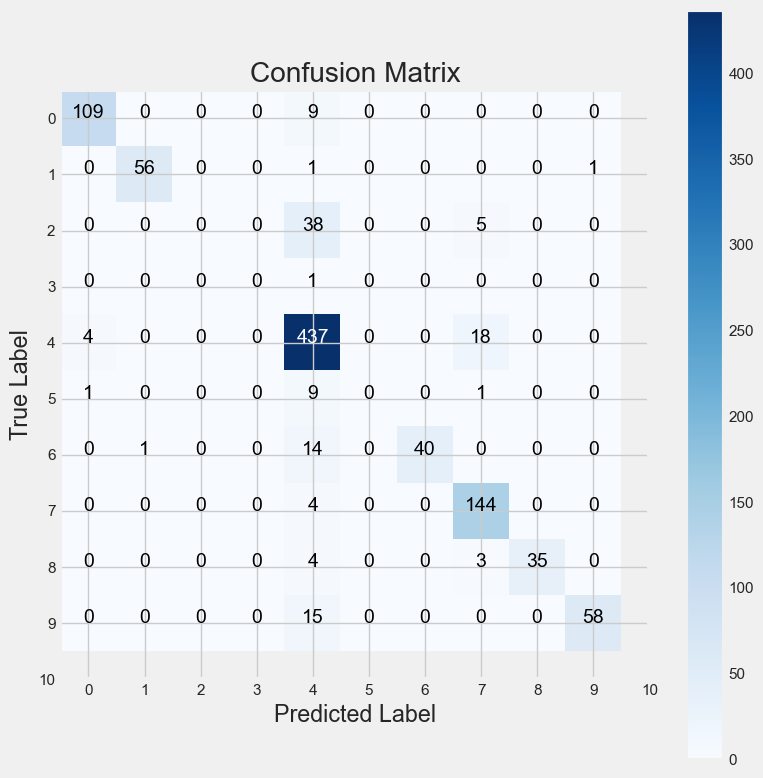

In [172]:
class_names = [i for i in range(n_clusters_cust)]
cnf_matrix  = confusion_matrix(y_val, svc.predictions)

np.set_printoptions(precision=2)

plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
    normalize=False, title='Confusion Matrix')

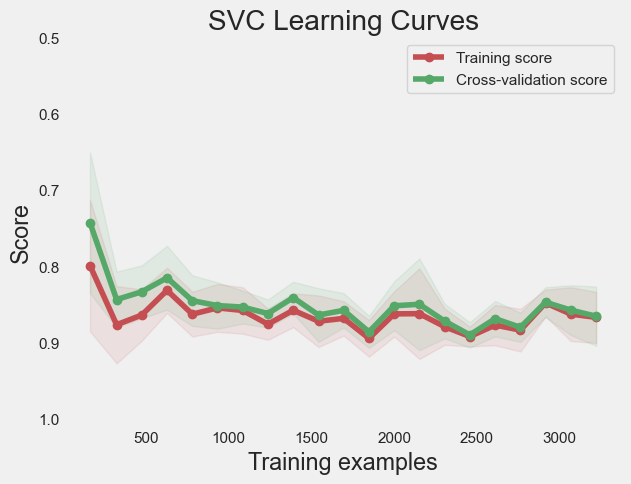

In [173]:
svc_lc = plot_learning_curve(svc.grid.best_estimator_,
    'SVC Learning Curves', X_train, y_train, ylim=[1.01, 0.5],
    cv = 5, train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### Logistic Regression

In [174]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C': np.logspace(-2, 2, 20)}], Kfold=5)
lr.grid_fit(X_train, y_train)

In [175]:
lr.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, lr.predictions) * 100)

Accuracy: 93.8492%


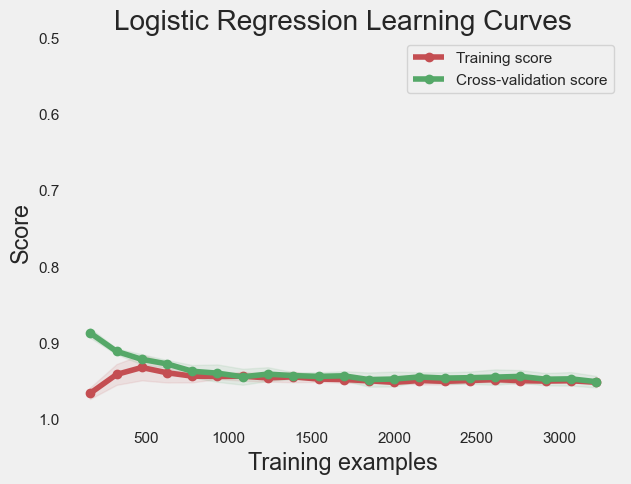

In [176]:
lr_lc = plot_learning_curve(lr.grid.best_estimator_, 
    'Logistic Regression Learning Curves', 
    X_train, y_train, ylim = [1.01, 0.5], cv = 5, 
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### K-Nearest Neighbors

In [177]:
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters=[{'n_neighbors': np.arange(1, 50, 1)}], Kfold=5)
knn.grid_fit(X_train, y_train)

In [178]:
knn.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, knn.predictions) * 100)

Accuracy: 83.4325%


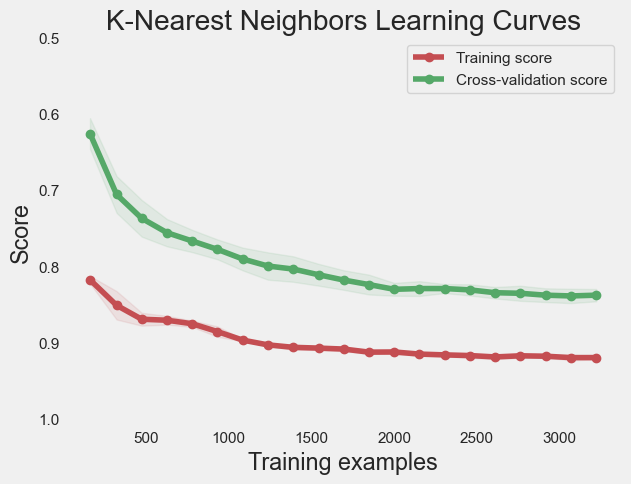

In [179]:
knn_lc = plot_learning_curve(knn.grid.best_estimator_,
    'K-Nearest Neighbors Learning Curves',
    X_train, y_train, ylim=[1.01, 0.5], cv=5, 
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### Decision Tree

In [180]:
dtree_params = {
    'criterion': ['entropy', 'gini'],
    'max_features':['sqrt', 'log2']
}

dtree = Class_Fit(clf = DecisionTreeClassifier)
dtree.grid_search(parameters=[dtree_params], Kfold=5)
dtree.grid_fit(X_train, y_train)

In [181]:
dtree.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, dtree.predictions) * 100)

Accuracy: 87.5000%


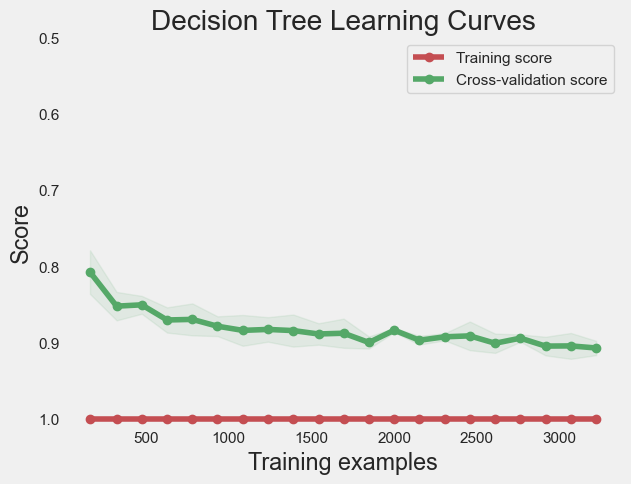

In [182]:
dtree_lc = plot_learning_curve(dtree.grid.best_estimator_,
    'Decision Tree Learning Curves',
    X_train, y_train, ylim = [1.01, 0.5], cv=5,
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### Random Forest

In [183]:
rf_params = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [20, 40, 60, 80, 100],
    'max_features': ['sqrt', 'log2']
}

rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = rf_params, Kfold=5)
rf.grid_fit(X_train, y_train)

In [184]:
rf.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, rf.predictions) * 100)

Accuracy: 93.5516%


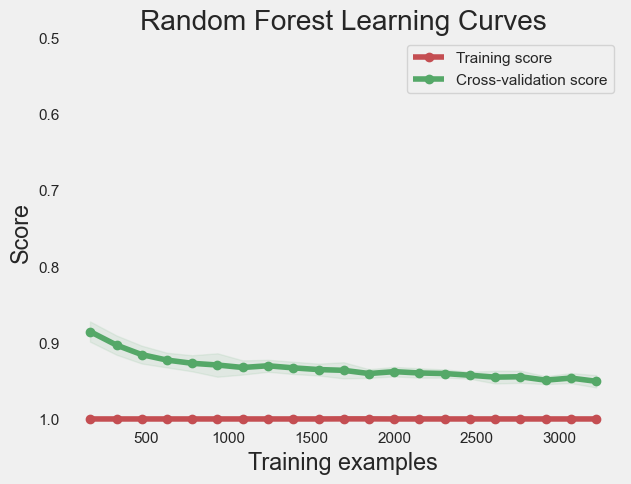

In [185]:
rf_lr = plot_learning_curve(rf.grid.best_estimator_,
    'Random Forest Learning Curves',
    X_train, y_train, ylim=[1.01, 0.5], cv=5,
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### AdaBoost

In [186]:
ada_params = {
    'n_estimators': [10, 20, 30, 40, 50, 
                     60, 70, 80, 90, 100]
}

ada = Class_Fit(clf = AdaBoostClassifier)
ada.grid_search(parameters=ada_params, Kfold=5)
ada.grid_fit(X_train, y_train)

In [187]:
ada.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, ada.predictions) * 100)

Accuracy: 64.0873%


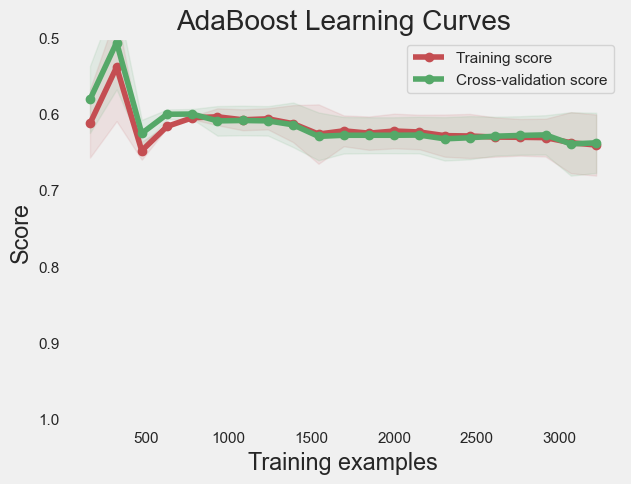

In [188]:
ada_lc = plot_learning_curve(ada.grid.best_estimator_,
    'AdaBoost Learning Curves', 
    X_train, y_train, ylim=[1.01, 0.5], cv=5,
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

### Gradient Boosting 

In [189]:
gb_params = {'n_estimators': [10, 20, 30, 40, 50, 
                              60, 70, 80, 90, 100]}

gb = Class_Fit(clf = GradientBoostingClassifier)
gb.grid_search(parameters=gb_params, Kfold=5)
gb.grid_fit(X_train, y_train)

In [190]:
gb.grid_predict(X_val, y_val)
classifier_accs.append(accuracy_score(y_val, gb.predictions) * 100)

Accuracy: 94.1468%


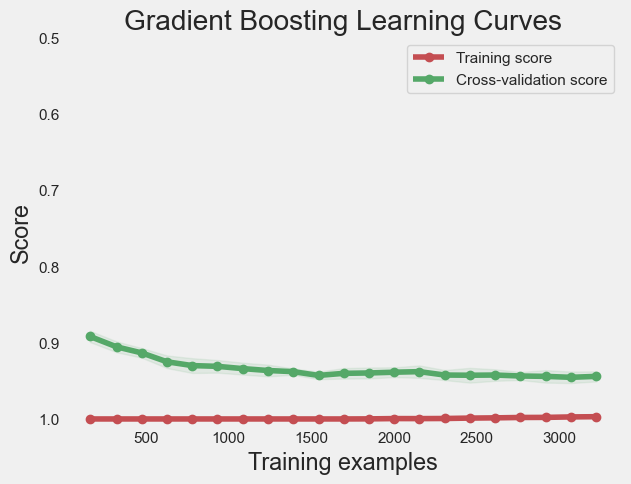

In [191]:
gb_lc = plot_learning_curve(gb.grid.best_estimator_,
    'Gradient Boosting Learning Curves',
    X_train, y_train, ylim=[1.01, 0.5], cv=5,
    train_sizes=np.r_[0.05, np.linspace(0.1, 1.0, 20)])

In [192]:
classifier_accs

[87.20238095238095,
 93.84920634920636,
 83.43253968253968,
 87.5,
 93.5515873015873,
 64.0873015873016,
 94.14682539682539]

In [193]:
d = {'classifier_name': classifier_names,
     'classifier_acc' : classifier_accs
}

df = pd.DataFrame(data=d)
df

,classifier_name,classifier_acc
0,Support Vector Machine,87.202381
1,Logistic Regression,93.849206
2,K-Nearest Neighbors,83.432540
3,Decision Tree,87.500000
4,Random Forest,93.551587
5,AdaBoost,64.087302
6,Gradient Boosting,94.146825


### Testing Predictions

We've trained each model into training set. Now we'll check the accuracies on where it matters: the test set. We'll do the same method on a new set: grouping data by invoices per customers, grouping them further into data per customers, and then classifying them using the models.

In [194]:
basket_price = test.copy(deep = True)

In [195]:
test

,Customer ID,Invoice,basket_price,InvoiceDate,ctg_0,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5
9,12347.0,562032,584.91,2011-08-02 08:48:00.000000000,38.25,61.30,109.70,158.16,119.70,97.80
10,12347.0,573511,1294.32,2011-10-31 12:25:00.000000256,76.50,145.30,200.60,392.12,424.20,55.60
11,12347.0,581180,224.82,2011-12-07 15:52:00.000000000,0.00,38.58,77.40,23.40,55.44,30.00
16,12348.0,568172,270.00,2011-09-25 13:13:00.000000000,0.00,0.00,270.00,0.00,0.00,0.00
19,12349.0,577609,1454.60,2011-11-21 09:51:00.000000000,150.50,79.32,477.56,188.30,200.57,358.35
...,...,...,...,...,...,...,...,...,...,...
36551,18283.0,578262,298.57,2011-11-23 13:27:00.000000512,0.00,59.56,111.08,0.00,127.93,0.00
36552,18283.0,579673,195.46,2011-11-30 12:58:59.999999744,0.00,26.25,75.87,9.75,83.59,0.00
36553,18283.0,580872,208.00,2011-12-06 12:02:00.000000256,0.00,27.07,93.10,0.00,87.83,0.00
36563,18287.0,570715,1001.32,2011-10-12 10:22:59.999999744,0.00,219.40,423.88,32.00,326.04,0.00


In [196]:
transactions_per_user = basket_price.groupby(['Customer ID']).agg({
    'basket_price': ['count', 'min', 'max', 'mean', 'sum']})
transactions_per_user.columns = [f'bp_{i[1]}' for i in
    transactions_per_user.columns.to_flat_index()]

for i in range(n_clusters_prod):
    ## Calculate percentage of sales in each category
    col = f'ctg_{i}'
    transactions_per_user.loc[:, f'pct_{col}'] = (
        basket_price.groupby(['Customer ID'])[col].sum() /
        transactions_per_user['bp_sum'] * 100)
    
# Adding days since first purchase and last purchase
time_of_purchase = basket_price.groupby(['Customer ID']).agg(
    first_purchase = ('InvoiceDate', lambda x: (last_date - x.min()).days),
     last_purchase = ('InvoiceDate', lambda x: (last_date - x.max()).days)
)
transactions_per_user = pd.concat([transactions_per_user, time_of_purchase], axis=1)
    
transactions_per_user = transactions_per_user.reset_index()
transactions_per_user.sort_values('Customer ID', ascending=True)[:5]
transactions_per_user

,Customer ID,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,first_purchase,last_purchase
0,12347.0,3,224.82,1294.32,701.350000,2104.05,5.453768,11.652765,18.426368,27.265512,28.485065,8.716523,129,1
1,12348.0,1,270.00,270.00,270.000000,270.00,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,74,74
2,12349.0,1,1454.60,1454.60,1454.600000,1454.60,10.346487,5.453046,32.831019,12.945140,13.788670,24.635639,18,18
3,12352.0,3,226.25,286.25,248.076667,744.23,3.426360,2.794835,28.109590,37.622778,5.916182,22.130255,79,35
4,12356.0,1,58.35,58.35,58.350000,58.35,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,18277.0,1,110.38,110.38,110.380000,110.38,0.000000,14.006161,30.186628,0.000000,11.415111,44.392100,57,57
3258,18278.0,1,173.90,173.90,173.900000,173.90,0.000000,0.000000,25.876941,63.944796,10.178263,0.000000,73,73
3259,18282.0,2,77.84,98.76,88.300000,176.60,28.878822,13.674972,12.995470,24.405436,20.045300,0.000000,125,7
3260,18283.0,9,1.95,298.57,132.906667,1196.16,1.333434,16.013744,40.167703,3.456895,37.820191,1.208032,147,3


As we can see the transaction starts from `2009/12/01` to `2011/12/09` (738 days) and we're taking the training set to`date_thres` of `2011-07-14` (590 days), leaving us with the rest of test set for 148 days (20% of data). We need to match the time within both training and tests. Therefore, we're weighing the test dataset to match the timespans by multiplying `bp_count` to 5.

In [197]:
## Correcting time range

## I am correcting the data to take into account 
## the ratio/difference in time between the two datasets 
## and weights the variables count and sum to 
## obtain an equivalence with the training set:

transactions_per_user['bp_count'] *= 5
transactions_per_user['bp_sum'] = (transactions_per_user['bp_count'] *
                                   transactions_per_user['bp_mean'])

transactions_per_user.sort_values('Customer ID', ascending=True)[:5]

,Customer ID,bp_count,bp_min,bp_max,bp_mean,bp_sum,pct_ctg_0,pct_ctg_1,pct_ctg_2,pct_ctg_3,pct_ctg_4,pct_ctg_5,first_purchase,last_purchase
0,12347.0,15,224.82,1294.32,701.350000,10520.25,5.453768,11.652765,18.426368,27.265512,28.485065,8.716523,129,1
1,12348.0,5,270.00,270.00,270.000000,1350.00,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,74,74
2,12349.0,5,1454.60,1454.60,1454.600000,7273.00,10.346487,5.453046,32.831019,12.945140,13.788670,24.635639,18,18
3,12352.0,15,226.25,286.25,248.076667,3721.15,3.426360,2.794835,28.109590,37.622778,5.916182,22.130255,79,35
4,12356.0,5,58.35,58.35,58.350000,291.75,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22,22


In [198]:
list_cols = transactions_per_user.columns[1:-2]

test_customers     = transactions_per_user.copy(deep = True)
cust_matrix_test   = test_customers[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(cust_matrix_test)

In [199]:
feature_cols = ['bp_mean'] + [f'pct_ctg_{i}' for i in range(n_clusters_prod)]

X_test = transactions_per_user[feature_cols]
y_test = kmeans.predict(scaled_test_matrix)

In [200]:
classifiers = [
    (svc, 'Support Vector Machine'),
    ( lr, 'Logistic Regression'),
    (knn, 'K-Nearest Neighbors'),
    (dtree, 'Decision Tree'),
    ( rf, 'Random Forest'),
    (ada, 'AdaBoost'),
    ( gb, 'Gradient Boosting')
]

classifier_test_accs = []

for clf, label in classifiers:
    print(f'{label}')
    clf.grid_predict(X_test, y_test)
    classifier_test_accs.append(
        accuracy_score(y_test, clf.predictions) * 100)

Support Vector Machine
Accuracy: 82.2808%
Logistic Regression
Accuracy: 91.5696%
K-Nearest Neighbors
Accuracy: 82.2195%
Decision Tree
Accuracy: 86.4500%
Random Forest
Accuracy: 90.9258%
AdaBoost
Accuracy: 57.7560%
Gradient Boosting
Accuracy: 90.6193%


### Voting Classifier

Now we've done predictions on each classifier, we'll take the best accuracies on test dataset, and make a `VotingClassifier` to improve the accuracy. 

Here we'll be taking three best classifiers from the accuracies above:
* `LogisticRegression`,
* `RandomForest`, and
* `GradientBoosting`.

It works by taking prediction on each row for each chosen classifier. compare the results (take the results of 1-0-1), and the majority votes will be the result of the classifier's prediction.

In [201]:
lr_best  = LogisticRegression(**lr.grid.best_params_)
rf_best  = RandomForestClassifier(**rf.grid.best_params_)
gb_best  = GradientBoostingClassifier(**gb.grid.best_params_)

In [202]:
votingC = VotingClassifier(estimators=[
    ('lr', lr_best), ('rf', rf_best), ('gb', gb_best)], voting='soft')

In [203]:
votingC = votingC.fit(X_train, y_train)

In [204]:
val_predictions = votingC.predict(X_val)
print(f'Validation Accuracy: {100*accuracy_score(y_val, val_predictions)}')

Validation Accuracy: 94.64285714285714


In [205]:
predictions = votingC.predict(X_test)
print(f'Accuracy: {100*accuracy_score(y_test, predictions)}')

Accuracy: 91.56958920907418


## Conclusion

We've done quite a lot on the project. We've made a product segmentation and customer segmentation of an online retail company. The project consists of:

* **EDA and Data Cleaning**: 
    * Exploring several columns and cleaning non-transactions, and 
    * cleaning invoices of cancellations into a new column for revenue calculation
* **Product Segmentation**: 
    * Visualizing word occurences in retail products, 
    * grouping products into categories through tokens of words into clusters, and 
    * Visualizing clusters' contents via `WordCloud` and their correlations via  PCA
* **Customer Classification**: 
    * Clustering of customering based on previous product categories, 
    * Visualizing each cluster in a `RadarChart`,
    * training 7 models for classification with respective learning curves, 
    * and using voting classifier to improve the accuracy.

As a result, we've cleaned 1M+ data of transactions into:
* **765000+ invoices of sales** with **respective cancellations in a column** for easier revenue calculation, with addition of
* data clustering into **6 categories of products and 11 categories of customers**, and 
* classification the customers using 3 best models inside of **`VotingClassifier` with a test accuracy of 91.5696%**.

The clusters could be beneficial for marketing purposes, where you could target advertisements, promotions, or discount depending on the criteria of clusters.